# Project Name

---

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)


## 1. Data Source Information <a name="datasource"></a>

---


## 2. Setup <a name="setup"></a>

---


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

from scipy.fft import fft
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
from sklearn.svm import SVR
import xgboost as xgb
#from prophet import Prophet

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

### 2.2. Importing the Data: <a name="dataimport"></a>

In [2]:
# Set directories
current_wdir = os.getcwd()
data_folder_hourly = current_wdir + '/Data/Hourly_Load'
data_folder_weather = current_wdir + '/Data/Weather'

In [3]:
# Add and sort all filenames from each folder path.
file_path_load = [f'{data_folder_hourly}/{file}' for file in os.listdir(data_folder_hourly) if '.csv' in file]
file_path_load = sorted(file_path_load)

file_path_weather = [f'{data_folder_weather}/{file}' for file in os.listdir(data_folder_weather) if '.csv' in file]
file_path_weather = sorted(file_path_weather)

# Iterate through filenames and add them to dataframe.
# pd.read_csv can unzip as it goes with compression argument.
load_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_load], join = 'outer', ignore_index = False, axis = 0)
weather_df_list = []
for filename in file_path_weather:
    # delimiter has whitespace after comma, specified here as \s+.
    temp_df = pd.read_csv(filename, compression = 'gzip', delimiter = ',\s+', engine = 'python')
    temp_df['zone']= os.path.basename(filename).replace('.csv.gz', '')
    weather_df_list.append(temp_df)
weather_df = pd.concat(weather_df_list, join = 'outer', ignore_index = False, axis = 0)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

In [4]:
display(load_df)
display(load_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,BC,BC,2358.000,True
1,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,AE,855.000,True
2,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,DPL,1150.000,True
3,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,JC,1632.000,True
4,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,ME,929.000,True
...,...,...,...,...,...,...,...,...
62605,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,RECO,RECO,131.877,False
62606,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PEP,SMECO,355.931,False
62607,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PL,UGI,101.478,True
62608,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,AE,VMEU,70.051,False


datetime_beginning_utc     object
datetime_beginning_ept     object
nerc_region                object
mkt_region                 object
zone                       object
load_area                  object
mw                        float64
is_verified                  bool
dtype: object

- There's a few columns encoding geographic region data with the regions indicating larger areas and zone/load_area denoting more specific areas. Zone will be useful to assign the weather data to.
- One datetime can be dropped. The vast majority of these regions are in the US Eastern timezone so 'datetime_beginning_ept' will be useful to keep for interpretability.
- is_verified denotes weather or not an electric company employee visually confirmed the load number on their meter. This will be ignored for this project.

Some datatype reformatting will have to be done on the date.

In [5]:
display(weather_df)
display(weather_df.dtypes)

,Date,MaxTemperature,MinTemperature,AvgTemperature,Precipitation,zone
0,2015-01-01,43,17,30.0,0.00,AE
1,2015-01-02,45,24,34.5,0.00,AE
2,2015-01-03,47,21,34.0,0.62,AE
3,2015-01-04,64,46,55.0,0.26,AE
4,2015-01-05,50,25,37.5,0.00,AE
...,...,...,...,...,...,...
11417,2024-04-05,57,40,48.5,0.00,PEP
11418,2024-04-06,57,41,49.0,0.00,PEP
11419,2024-04-07,65,43,54.0,0.00,PEP
11420,2024-04-08,71,44,57.5,0.00,PEP


Date              object
MaxTemperature    object
MinTemperature    object
AvgTemperature    object
Precipitation     object
zone              object
dtype: object

All of these will potentially be useful as covariates in the models.

The sample rates between datasets are mismatched - electric load data is hourly and this weather data is daily. This will require either load resampling and aggregation or assigning this weather data to each hour as a static daily feature.

### 3.2. Reformating: <a name="reformat"></a>

Convert the dates into datatime objects.

In [6]:
# Convert to datetime. The two dataframes share column names.
date_cols = ['datetime_beginning_utc', 'datetime_beginning_ept']
load_df[date_cols] = load_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)
weather_df['Date'] = weather_df['Date'].apply(pd.to_datetime, format = '%Y-%m-%d', utc = False)

### 3.3. Discovery: <a name="discovery"></a>

Since the `zone` column will likely be used to group the data by, we can start by grouping the data by `zone` and `date` and plot over time.

In [7]:
load_zone_df = load_df[['datetime_beginning_ept', 'zone', 'mw']].groupby(['datetime_beginning_ept', 'zone'], as_index = False).sum()

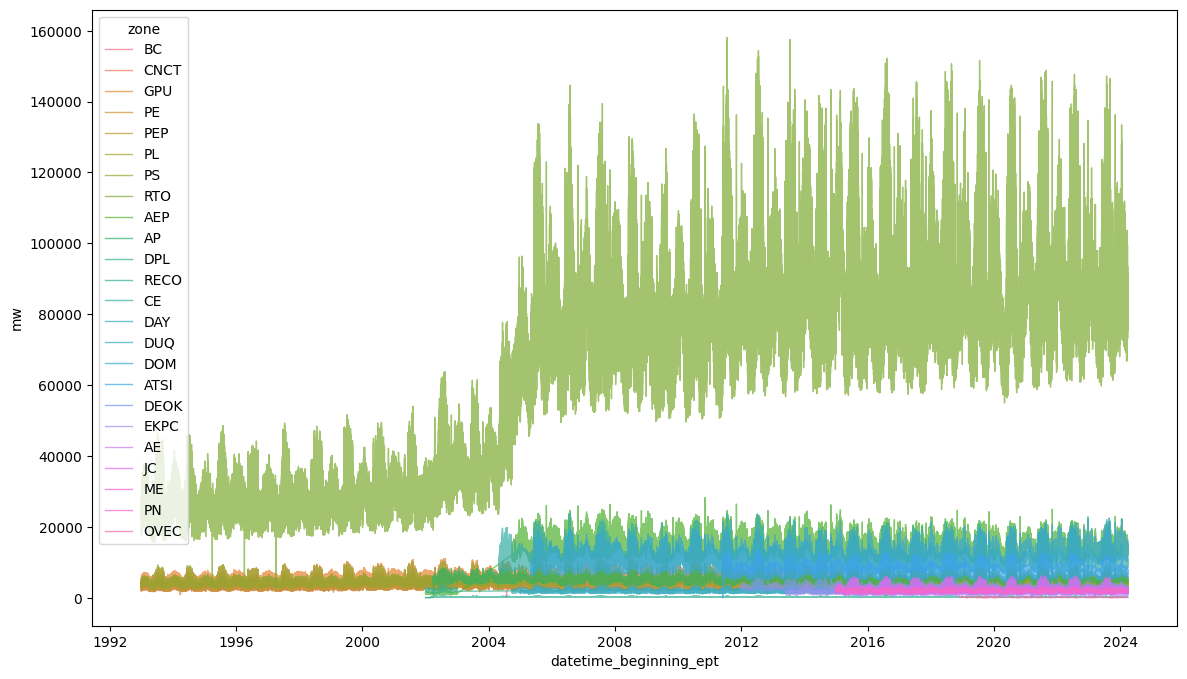

In [8]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_zone_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'zone', alpha = 0.7, lw = 1)

Zone 'RTO' seems to be on a different scale and looks like an aggregate sum of all the zones. This is likely to be the case because 'RTO' stands for Regional Transmission Organization which is exactly where this data came from.

Let's confirm this by dropping the 'RTO' zone, summing the remaining zones and overlaying it on the previous plot.

In [9]:
load_noRTO_df = load_zone_df.drop(load_zone_df[load_zone_df['zone'] == 'RTO'].index)

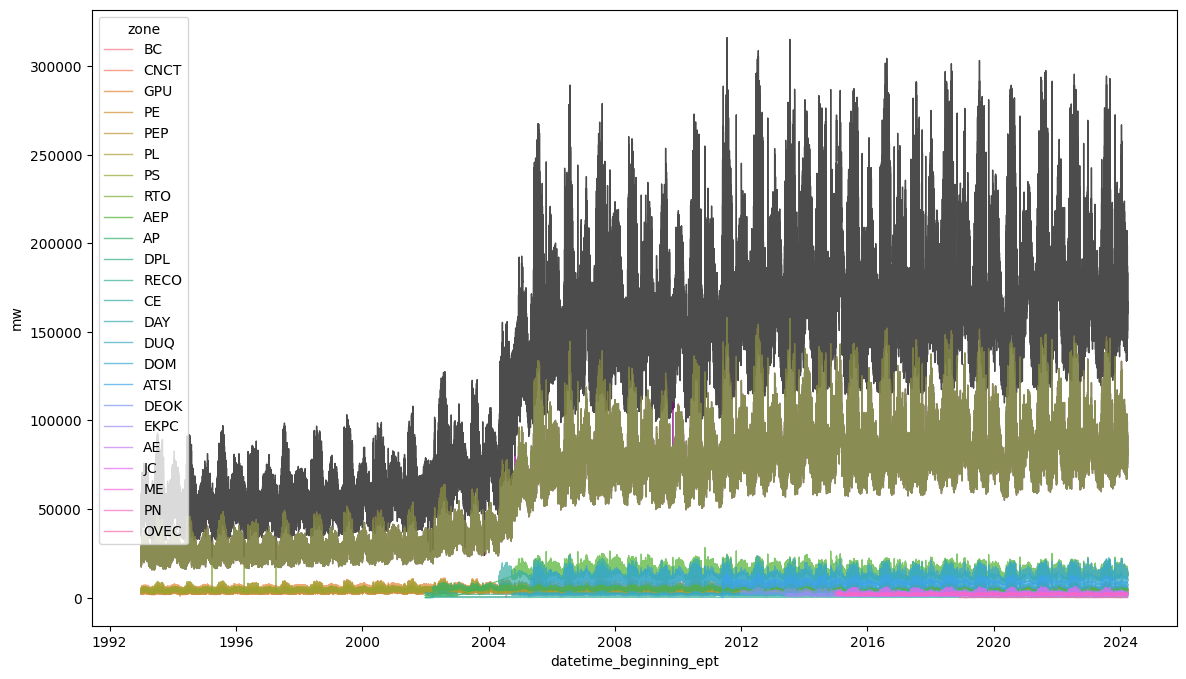

In [10]:
ax, fig = plt.subplots(figsize = (14, 8))
# Black - Sum of ALL
ax = sns.lineplot(load_zone_df[['datetime_beginning_ept', 'mw']].groupby(['datetime_beginning_ept'], as_index = False).sum(), x = 'datetime_beginning_ept', y = 'mw', alpha = 0.7, lw = 1, c = 'black')
# Purple - Sum of All but NO RTO
ax = sns.lineplot(load_noRTO_df[['datetime_beginning_ept', 'mw']].groupby(['datetime_beginning_ept'], as_index = False).sum(), x = 'datetime_beginning_ept', y = 'mw', alpha = 0.7, lw = 1, c = 'purple')
ax = sns.lineplot(load_zone_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'zone', alpha = 0.7, lw = 1)

Besides a few artifacts in the data, it looks like that was the case. We can get rid of RTO since forecasting an aggregated time series signal isn't the goal here.

Next, more information is needed about how many zones there are and where they are located.

In [11]:
sorted(load_df['zone'].unique())

['AE',
 'AEP',
 'AP',
 'ATSI',
 'BC',
 'CE',
 'CNCT',
 'DAY',
 'DEOK',
 'DOM',
 'DPL',
 'DUQ',
 'EKPC',
 'GPU',
 'JC',
 'ME',
 'OVEC',
 'PE',
 'PEP',
 'PL',
 'PN',
 'PS',
 'RECO',
 'RTO']

Here we can manually look at these zones and research where they are located. This information is important to align the weather data. Most of them easily identified with a map from the data source (can be found in section 3.4).

**Zones:**

- `AE` - New Jersey
- `AEP` - Ohio
- `AP` - West Virginia
- `ATSI` - Ohio
- `BC` - Maryland
- `CE` - Northern Illinois
- `CNCT` - Connecticut
- `DAY` - Ohio
- `DEOK` - Ohio
- `DOM` - Virginia
- `DPL` - Connecticut
- `DUQ` - Pennsylvania
- `EKPC` - Kentucky
- `GPU` - New Jersey
- `JC` - New Jersey
- `ME` - Pennsylvania
- `OVEC` - Ohio
- `PE` - Pennsylvania
- `PEP` - Maryland
- `PL` - Pennsylvania
- `PN` - Pennsylvania
- `PS` - New Jersey
- `RECO` - New Jersey

- `RTO` - Regional Transmission Organization (PJM) - Aggregated Sum

Forecasting ALL of these zones is beyond the scope and computational limitations of this project, because of this let's build out a function to visualize each zone and choose a few that are interesting that will be used to build the models and perform predictions on.

In [12]:
def load_zone_plot(zone_df, outliers=None, figsize=(16,16), cmap=None):
    """Finds all unique zone names and prints to output (n x 2) subplot array of line plots where x = datetime vs y = MW. 
    Can handle any length of list of strings.

    Parameters:
        zones_df (list): Pandas dataframe grouped by zone and time such as load_zone_df.
    Optional Parameters:
        outliers (dict): List of outlier indexes that will be plotted as points on top of line plot. Has the form of {'Zone' : [idx, idx, ...]}
        figsize (tuple): Default = (16,16)
    Returns:
        None. Prints plot to output."""
    
    zone_list = zone_df['zone'].unique()

    color_pal = ['#005d5d', '#017d66']
    
    fig, ax = plt.subplots(int(np.ceil(len(zone_list)/2)), 2, figsize = figsize, sharey = False, sharex = False)
    for i, zone in enumerate(zone_list):
        #print(f'{i} {zone} -- [{i//2}, {i%2}]')
        # i iterates through axes rows and columns with // and % operators 
        # ([0,0] to [0,1] to [1,0] ... etc).
        sns.lineplot(load_zone_df.loc[load_zone_df['zone'] == zone], ax = ax[i//2, i%2], 
                     x = 'datetime_beginning_ept', y = 'mw', 
                     alpha = 0.7, lw = 1,
                     c = cmap[zone] if cmap else (color_pal[int(i % 4 < 2)]))
        ax[i//2, i%2].set_title(zone, y = 1)
        ax[i//2, i%2].set_xlabel(None)
        ax[i//2, i%2].set_ylabel(None)

        # If given outlier indexes, plot them.
        if outliers:
            sns.scatterplot(load_zone_df.iloc[outliers.get(zone)], ax = ax[i//2, i%2],
                            x = 'datetime_beginning_ept', y = 'mw',
                            c = 'black')
        
    plt.subplots_adjust(wspace = 0.3, hspace = 1)
    fig.suptitle('Hourly Load of Each Zone')
    fig.supxlabel('Datetime')
    fig.supylabel('Megawatts (MW)')
    fig.tight_layout()

    # Check if odd number of plots and delete last subplot if true.
    if len(zone_list) % 2 != 0:
        fig.delaxes(ax[i // 2, (len(zone_list) % 2)])
    
    return None

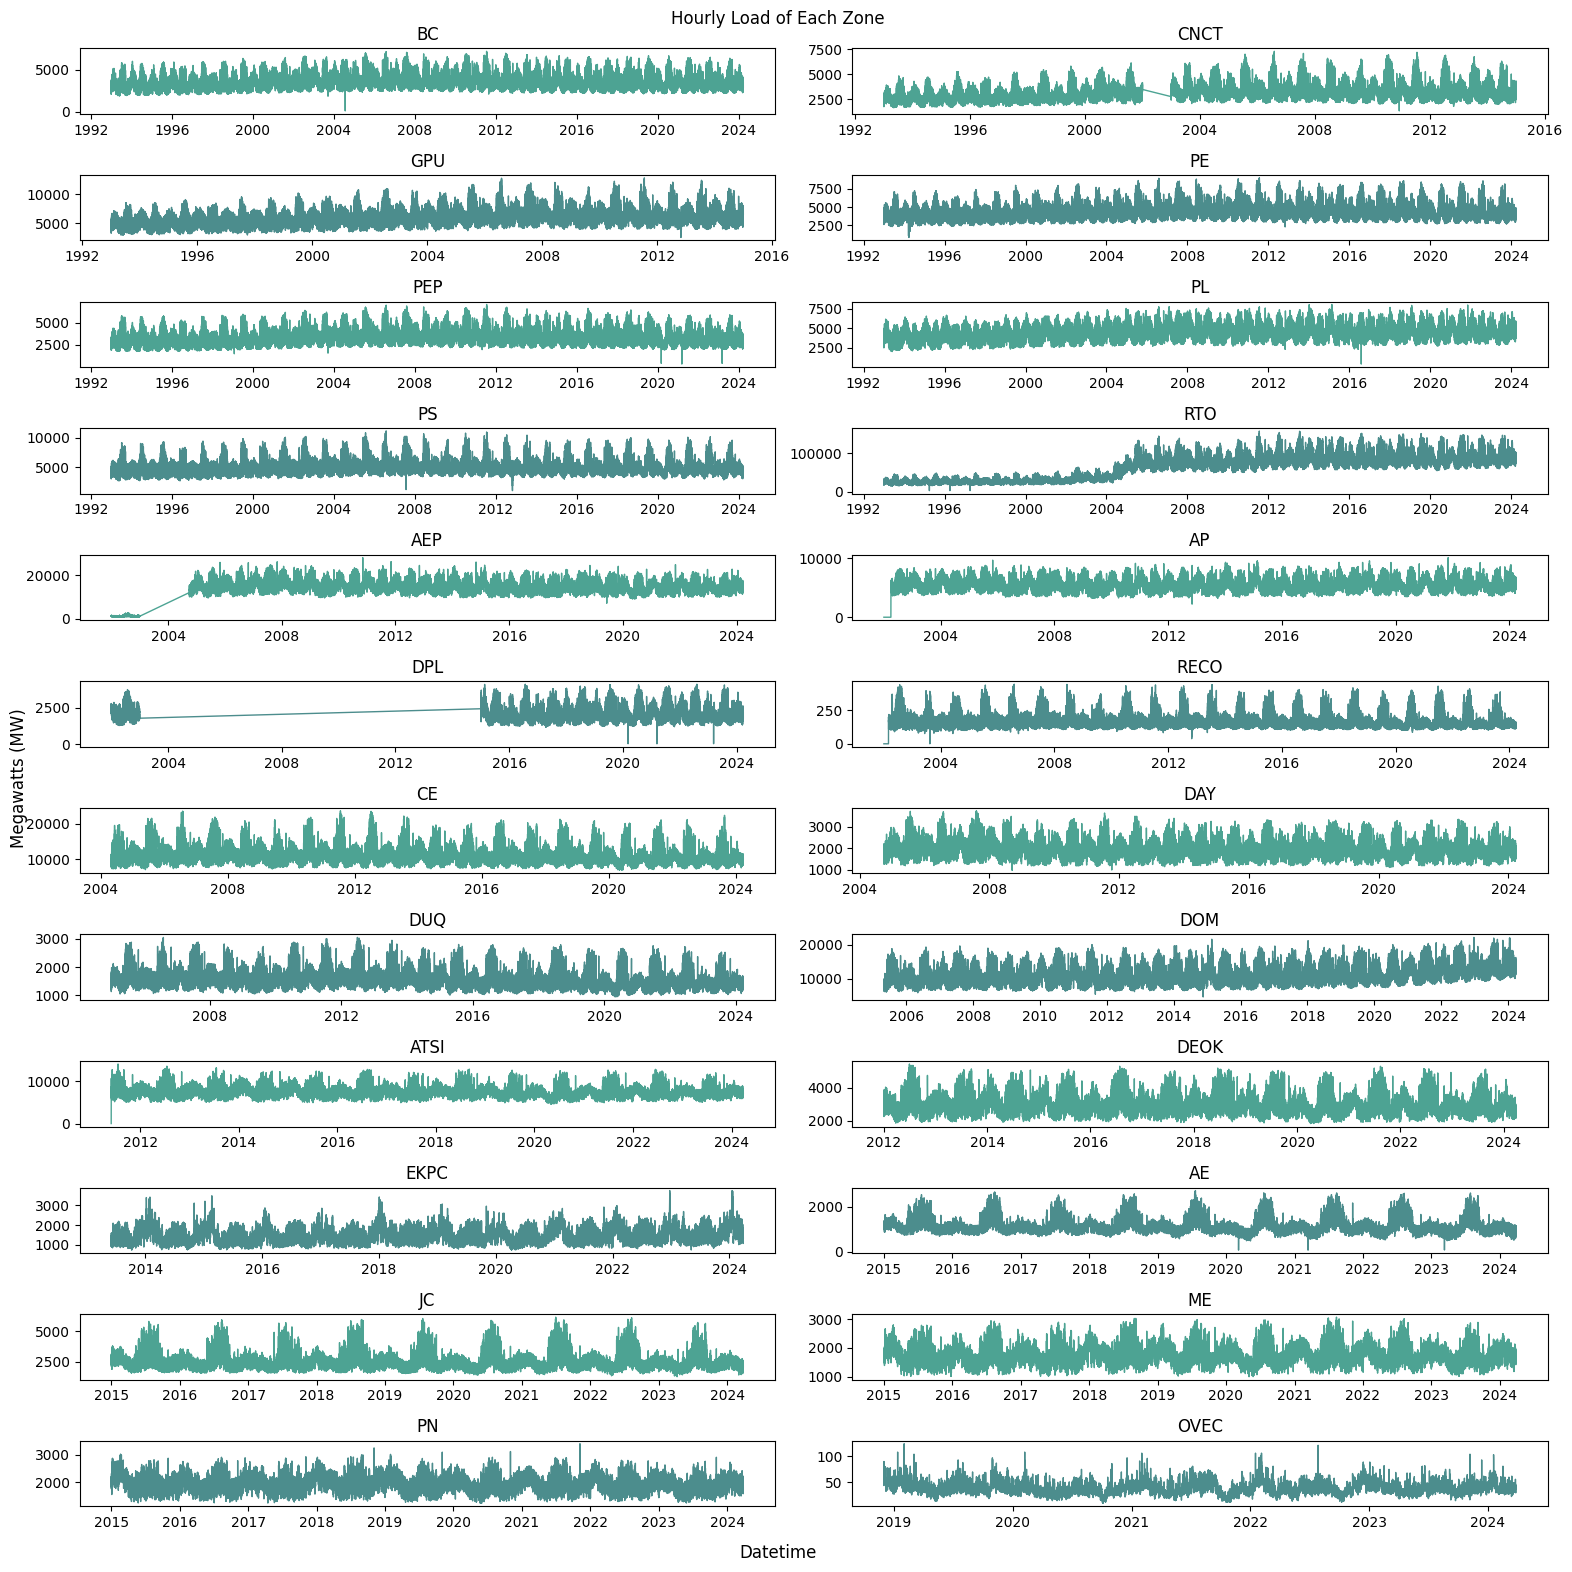

In [13]:
load_zone_plot(load_zone_df)

### 3.4. Selecting Electrical Load Data: <a name="dataselection"></a>

The following zones will be chosen for the remainder of this project.

- `AE`: Atlantic City Electric Co. 
- `CE`: ComEd
- `DOM`: Dominion
- `JC`: Jersey Central Power & Light
- `PEP`: Potomac Electric Power Co.

In [14]:
zones = ['AE', 'CE', 'DOM', 'JC', 'PEP']
load_zone_df = load_zone_df.loc[load_zone_df['zone'].isin(zones)]
load_zone_df.reset_index(drop = True, inplace = True)

# Color map zones for consistency.
palette = ['#570408', '#005d5d', '#1192e8', '#fa4d56', '#012749']
zones_palette = dict(zip(zones, palette))

*Note about the weather data:*

After choosing zones to work with, weather data was sourced from National Oceanic and Atmospheric Administration's (NOAA) Regional Climate Center (RCC) Applied Climate Information System (ACIS). Detailed information can be found in section 1. For readability and organizational purposes the weather data was imported above along with the other datasets.

Ideally, the sampling rate would match the hourly load data, however, only daily weather data is available at this time.

A weather station was chosen for each zone. The criteria considered for the weather station was:
- Geographically central to the listed zone.
- Weather station uptime reliability (airport weather stations often chosen for this quality.)

**Weather Stations Chosen:**
- `AE`: MILLVILLE MUNICIPAL AIRPORT, NJ 
- `CE`: CHICAGO OHARE INTL AP, IL
- `DOM`: RICHMOND INTERNATIONAL AP, VA
- `JC`: NEW BRUNSWICK 3 SE, NJ
- `PEP`: WASHINGTON REAGAN NATIONAL AIRPORT, VA

<img src="Images/Zones.png" alt="Zones" width="550"/>

(Map Source: https://www.pjm.com/-/media/about-pjm/pjm-zones.ashx)

### 3.5. Missing Data: <a name="missingdata"></a>

#### 3.5.1. Missing Dates - Where Has the Time Gone?: <a name="missingdates"></a>

Some but not all of the models require the sample frequency to have no missing samples (in this case hours in `load_df` and days in `weather_df` - they will be joined later where the weather data will become hourly static features.). 

**Method:**
1. Store any missing datetimes.
2. For any found missing datetimes, the average of the previous and next observed data is used to fill in the missing data.

In [15]:
# Could also use .asfreq('H') which would assign any missing rows to NaN then identify rows.
print('######### Check for Missing Weather Dates #########')
for zone in zones:
    # Find min and max dates for that zone.
    date_min = weather_df.loc[weather_df['zone'] == zone]['Date'].min()
    date_max = weather_df.loc[weather_df['zone'] == zone]['Date'].max()
    print(f'{zone} - {date_min} | {date_max}')
    # Find missing dates.
    # Weather DF - Set freq to 'D' for days.
    miss_date = pd.date_range(start = date_min, end = date_max, freq = 'D').difference(weather_df['Date'])
    print(f"{'':<5}Missing Dates: {miss_date if len(miss_date) > 0 else False}")

print('\n######### Check for Missing Energy Dates #########')
for zone in zones:
    # Find min and max dates for that zone.
    date_min = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].min()
    date_max = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].max()
    print(f'{zone} - {date_min} | {date_max}')
    # Find missing dates. 
    # Load DF - Set freq to 'H' for hours.
    miss_date = pd.date_range(start = date_min, end = date_max, freq = 'H').difference(
        load_zone_df['datetime_beginning_ept'].loc[load_zone_df['zone'] == zone])
    print(f"{'':<5}Missing Dates: {miss_date if len(miss_date) > 0 else False}")

    # Check to see if missing dates exist.
    # Fill missing dates with average of two surrounding times.
    # TODO: There's definitely some optimizations to be had here.
    if len(miss_date) > 0:
        print(f"{'':<5}============================================================")
        print(f"{'':<5}Adding Average of Surrounding Times to {zone} Missing Dates")
        # Find index of one hour before and after missing
        miss_pre_index = (load_zone_df.loc[(load_zone_df['zone'] == zone) & 
                                           (load_zone_df['datetime_beginning_ept'].isin(
                                               miss_date - pd.Timedelta(hours = 1)))]).index
        miss_post_index = (load_zone_df.loc[(load_zone_df['zone'] == zone) & 
                                            (load_zone_df['datetime_beginning_ept'].isin(
                                                miss_date + pd.Timedelta(hours = 1)))]).index
        # Calculate average of two surround times.
        miss_avg = [np.round(np.mean((a,b)), 3) for a, b in 
                    (zip(load_zone_df.iloc[miss_pre_index]['mw'], load_zone_df.iloc[miss_post_index]['mw']))]
        # Create DF to hold values and concat to main DF.
        temp_df = pd.DataFrame({'datetime_beginning_ept' : miss_date,
                    'zone' : zone,
                    'mw' : miss_avg})
        load_zone_df = pd.concat([load_zone_df, temp_df], join = 'outer', ignore_index = False, axis = 0)
        print(f"{'':<5}{'='*5} Done!\n")

######### Check for Missing Weather Dates #########
AE - 2015-01-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False
CE - 2004-05-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False
DOM - 2005-05-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False
JC - 2015-01-01 00:00:00 | 2024-04-10 00:00:00
     Missing Dates: False
PEP - 1993-01-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False

######### Check for Missing Energy Dates #########
AE - 2015-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: DatetimeIndex(['2015-03-08 02:00:00', '2016-03-13 02:00:00',
               '2017-03-12 02:00:00', '2018-03-11 02:00:00',
               '2019-03-10 02:00:00', '2020-03-08 02:00:00',
               '2021-03-14 02:00:00', '2022-03-13 02:00:00',
               '2023-03-12 02:00:00', '2024-03-10 02:00:00'],
              dtype='datetime64[ns]', freq=None)
     Adding Average of Surrounding Times to AE Missing Dates
     ===== Done!

CE - 2004-05-01 00:00:00 | 2

`weather_df` had no missing dates, so a solution to add date rows was not implemented.

Now to recheck `load_df` to make sure our data injection worked.

In [16]:
for zone in zones:
    # Find min and max dates for that zone.
    date_min = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].min()
    date_max = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].max()
    print(f'{zone} - {date_min} | {date_max}')
    # Find missing dates. 
    # Load DF - Set freq to 'H' for hours.
    miss_date = pd.date_range(start = date_min, end = date_max, freq = '1H').difference(
        load_zone_df['datetime_beginning_ept'].loc[load_zone_df['zone'] == zone])
    print(f"{'':<5}Missing Dates: {miss_date if len(miss_date) > 0 else False}")

# Sort by date and reset index.
load_zone_df = load_zone_df.sort_values(by = 'datetime_beginning_ept').reset_index(drop = True)

AE - 2015-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
CE - 2004-05-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
DOM - 2005-05-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
JC - 2015-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
PEP - 1993-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False


#### 3.5.2. Missing Weather Data: <a name="missingweather"></a>

Though the weather dataset was not missing any days, according to NOAA, the data logged may have a abbreviations for certain circumstances or measurement errors. 

According to their glossary, weather station data may have the follow:

- **M** = Missing (No measurement.)
- **T** = Trace Amount (Precipitation)

These values need to be located and handled in different ways.

- **M**: A window of 6 days (3 before and 3 after) will be created and the average measurement taken.
- **T**: T will be replaced with a comparable measurement on this scale, 0.01.

In [17]:
# Find unique non-numeric labels and assign values depending on col
for col in weather_df.columns[1:5]:
    search_str = set(weather_df[col].unique().astype(str))
    unique_strings = {x for x in search_str if x.isalpha()}
    print(f"{col} | Unique Strings: {unique_strings if len(unique_strings) > 0 else False}")

    if col == 'Precipitation':
        weather_df[col] = weather_df[col].mask(weather_df[col] == 'T', '0.01') # Trace
        weather_df[col] = weather_df[col].mask(weather_df[col] == 'M', '0.00') # Missing
        continue # Move on to next iteration.
    
    # Can handle Min, Max, Avg columns the same.
    # Take surrounding 6 values (by date) and average them to get missing value.
    m_index = weather_df.loc[weather_df[col] == 'M']

    # TODO: Perform and exorcism on this section....
    # Not ideal, could arise that Max < Min, or Avg isn't calc from Min and Max, etc.
    # AE is the only zone with M values, hard coded for now.
    m_df = pd.DataFrame({
        '3' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] + pd.Timedelta(days=3))) & (weather_df['zone'] == 'AE')].to_list(),
        '2' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] + pd.Timedelta(days=2))) & (weather_df['zone'] == 'AE')].to_list(),
        '1' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] + pd.Timedelta(days=1))) & (weather_df['zone'] == 'AE')].to_list(),
        '0' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] + pd.Timedelta(days=0))) & (weather_df['zone'] == 'AE')].to_list(),
        '-1' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] - pd.Timedelta(days=1))) & (weather_df['zone'] == 'AE')].to_list(),
        '-2' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] - pd.Timedelta(days=2))) & (weather_df['zone'] == 'AE')].to_list(),
        '-3' : weather_df[col].loc[(weather_df['Date'].isin(m_index['Date'] - pd.Timedelta(days=3))) & (weather_df['zone'] == 'AE')].to_list(),
        },index = m_index.index)

    m_df = m_df.apply(pd.to_numeric, errors = 'coerce')
    m_df['new_values'] = (np.round(m_df.mean(axis = 1)))
    # Assign new average to missing cells.
    weather_df.iloc[m_df.index, weather_df.columns.get_loc(col)] = m_df['new_values']

# Return original dtypes to columns and reset index.
weather_df['MaxTemperature'] = weather_df['MaxTemperature'].astype('int')
weather_df['MinTemperature'] = weather_df['MinTemperature'].astype('int')
weather_df.reset_index(drop = True, inplace = True)

MaxTemperature | Unique Strings: {'M'}
MinTemperature | Unique Strings: {'M'}
AvgTemperature | Unique Strings: {'M'}
Precipitation | Unique Strings: {'T', 'M'}


To quickly check if any remain, the numeric columns can be cast as numeric type and any remaining string characters will automatically be change to NaN. Then each will be checked for any NaN values.

In [18]:
# Change numeric columns to numeric and coerce all remaining errors/non-numbers to NaN.
weather_df[['MaxTemperature', 'MinTemperature', 'AvgTemperature', 'Precipitation']] = weather_df[
    ['MaxTemperature', 'MinTemperature', 'AvgTemperature', 'Precipitation']].apply(pd.to_numeric, errors = 'coerce')
weather_df.isna().sum()

Date              0
MaxTemperature    0
MinTemperature    0
AvgTemperature    0
Precipitation     0
zone              0
dtype: int64

Looks like it has been cleaned up.

Now that they are in their proper numeric format, .describe() can be used to get a better picture of their distributions.

In [19]:
display(weather_df.describe())
weather_df.dtypes

,Date,MaxTemperature,MinTemperature,AvgTemperature,Precipitation
count,32400,32400.000000,32400.000000,32400.000000,32400.000000
mean,2013-07-11 13:54:42.666666496,66.006204,47.391914,56.698920,0.121390
min,1993-01-01 00:00:00,-10.000000,-23.000000,-16.500000,0.000000
25%,2008-04-12 00:00:00,51.000000,34.000000,42.500000,0.000000
50%,2015-05-28 00:00:00,68.000000,48.000000,57.500000,0.000000
75%,2019-11-03 00:00:00,82.000000,63.000000,72.500000,0.050000
max,2024-04-10 00:00:00,105.000000,84.000000,93.500000,7.610000
std,NaN,18.895985,17.544789,17.896425,0.340688


Date              datetime64[ns]
MaxTemperature             int64
MinTemperature             int64
AvgTemperature           float64
Precipitation            float64
zone                      object
dtype: object

Nothing looks out of the ordinary and within reason.

### 3.6. Outlier Investigation: <a name="outlier"></a>

From the previous plots a few outliers could be seen. No matter the source of these outliers, be it systematic like scheduled maintenance, system downtime after a storm, or measurement errors, it will be important to remove them before training the models.

First, let's take a closer look at the chosen zones.

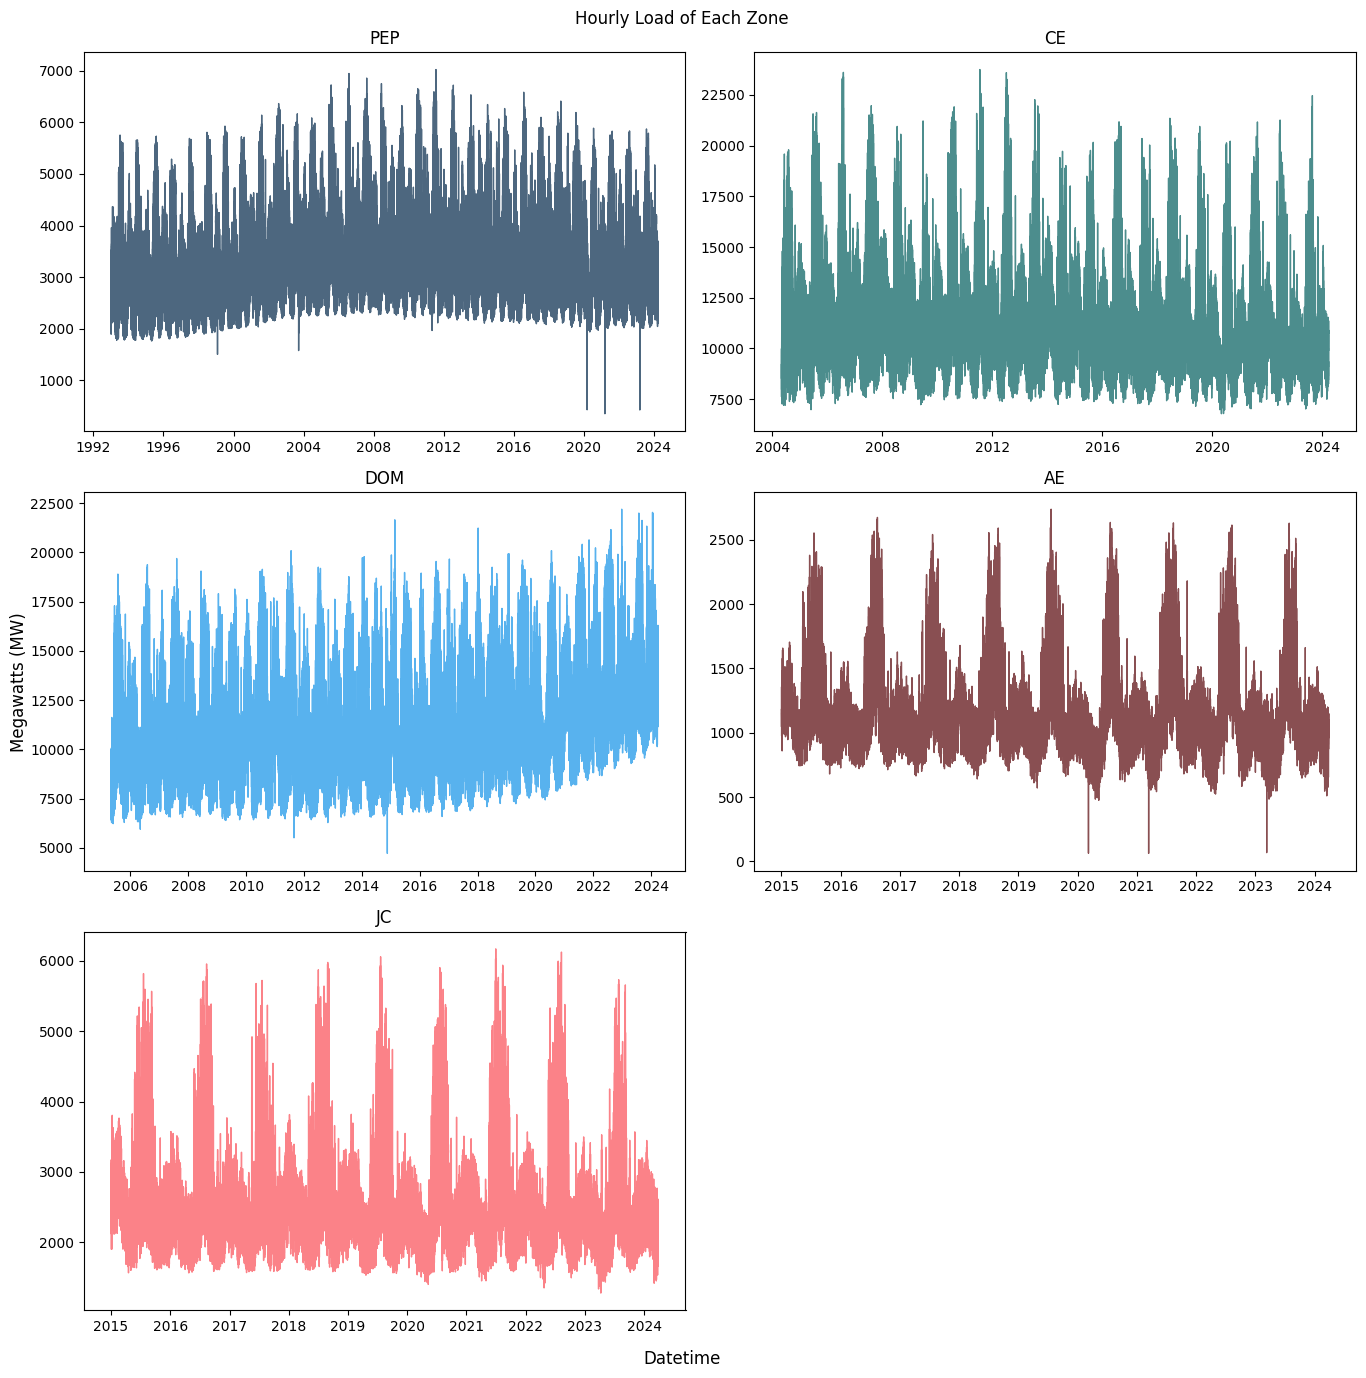

In [20]:
load_zone_plot(load_zone_df, figsize = (14,14), cmap = zones_palette)

`PEP`, `DOM`, and `AE` each have obvious outliers. A method to detect them needs to be chosen. It seems a quantile threshold approach could be effective in this case.

Here a test an be done to get an idea how far the threshold needs to be set by listing small slices of quantiles.

In [21]:
load_zone_df.loc[load_zone_df['zone'] == 'PEP']['mw'].quantile([0.00005, 0.01, 0.99, 0.9995])

0.00005    1755.867458
0.01000    2029.000000
0.99000    5626.516500
0.99950    6445.806363
Name: mw, dtype: float64

This looks right because from the `PEP` plot it can be seen most of the obvious outliers are somewhere below 1800 `mw`.

Here a detection method will be implemented.

1. Create a tumbling window that chronologically captures 35 days at a time.
2. Calculate the median `mw` value within that 35 day window.
3. With the median, calculate an upper and lower bound threshold by taking:
    - $Median \pm (QuantileScalar * S)$
        - where, $S =$ Window Standard Deviation
4. Log the index of any data point `mw` outside the threshold.
5. The median of that window will be logged so the outlier can be replaced with it.
6. The tumbling window will continue until the end of the dataset.

Along with this method a z-score method will be implemented as well and whichever method seems to capture more of the true outliers, will be used.

Z-Score Method:
- Calculate the z-score for each data point and calibrate/set a threshold number where if the z-score is outside of it, that point is an outlier.
    - $Z = \frac{x-\mu}{\sigma}$

In [22]:
outliers_index = {}
outliers_z = {}
replacement_medians = {}
for zone in zones:
    outliers_index[zone] = []
    outliers_z[zone] = []
    zone_df = load_zone_df.loc[load_zone_df['zone'] == zone]
    # Find min and max dates for that zone.
    date_min = zone_df['datetime_beginning_ept'].min()
    date_max = zone_df['datetime_beginning_ept'].max()
    # Create tumbling window to locally detect outliers.
    window_size = 35 # Days
    left = date_min
    right = left + pd.Timedelta(days = window_size)
    
    # Tumbling window calculates outlier thresholds 
    # Two methods: Quantile_Thresh = (median +/- (scalar*SD)) or Zscore = z >/< thresh.
    # Wasn't aware of the df.rolling() window method until after, could use instead.
    for i in range(int(((date_max-date_min) / pd.Timedelta(days = window_size)) + 1)):
        if right > date_max:
            right = date_max

        window_df = zone_df.loc[(zone_df['datetime_beginning_ept'].between(left, right, inclusive = 'both'))]

        w_std = window_df['mw'].std()
        w_median = window_df['mw'].median()
        q_lower, q_upper = w_median - (5.75*w_std), w_median + (5.75*w_std) # quantile
        w_mean = window_df['mw'].mean()
        w_zscore = (window_df['mw'] - w_mean) / w_std # zscore

        # Quantile and zscore methods.
        outliers_temp = list(window_df.loc[(window_df['mw'] < q_lower) | (window_df['mw'] > q_upper)].index)
        outliers_z_temp = list(w_zscore.loc[(w_zscore < -5.5) | (w_zscore > 5.5)].index)
        # Store outliers if detected.
        if len(outliers_temp) > 0:
            outliers_index[zone].extend(outliers_temp)
            for i in outliers_temp:
                replacement_medians[i] = round(w_median, 3)
        if len(outliers_z_temp) > 0:
            outliers_z[zone].extend(outliers_z_temp)
        # Iterate window pointers
        left = right + pd.Timedelta(hours = 1)
        right = right + pd.Timedelta(days = window_size)

In [23]:
outliers_z

{'AE': [598305, 626861, 671381, 715061, 730185],
 'CE': [366819, 583181, 626862, 671382, 758744],
 'DOM': [129939, 261988, 288196, 314405, 626863, 671383, 715063, 758745],
 'JC': [626864, 671384],
 'PEP': [598301, 642824, 671385, 730181, 758741]}

In [24]:
outliers_index

{'AE': [598305, 626861, 671381, 715061, 730185],
 'CE': [583181, 626862, 758744],
 'DOM': [261988, 626863, 671383, 715063, 758745],
 'JC': [],
 'PEP': [598301, 642824, 730181]}

The `load_zone_plot` function was altered to take the index of any outliers and plot them with a black point.

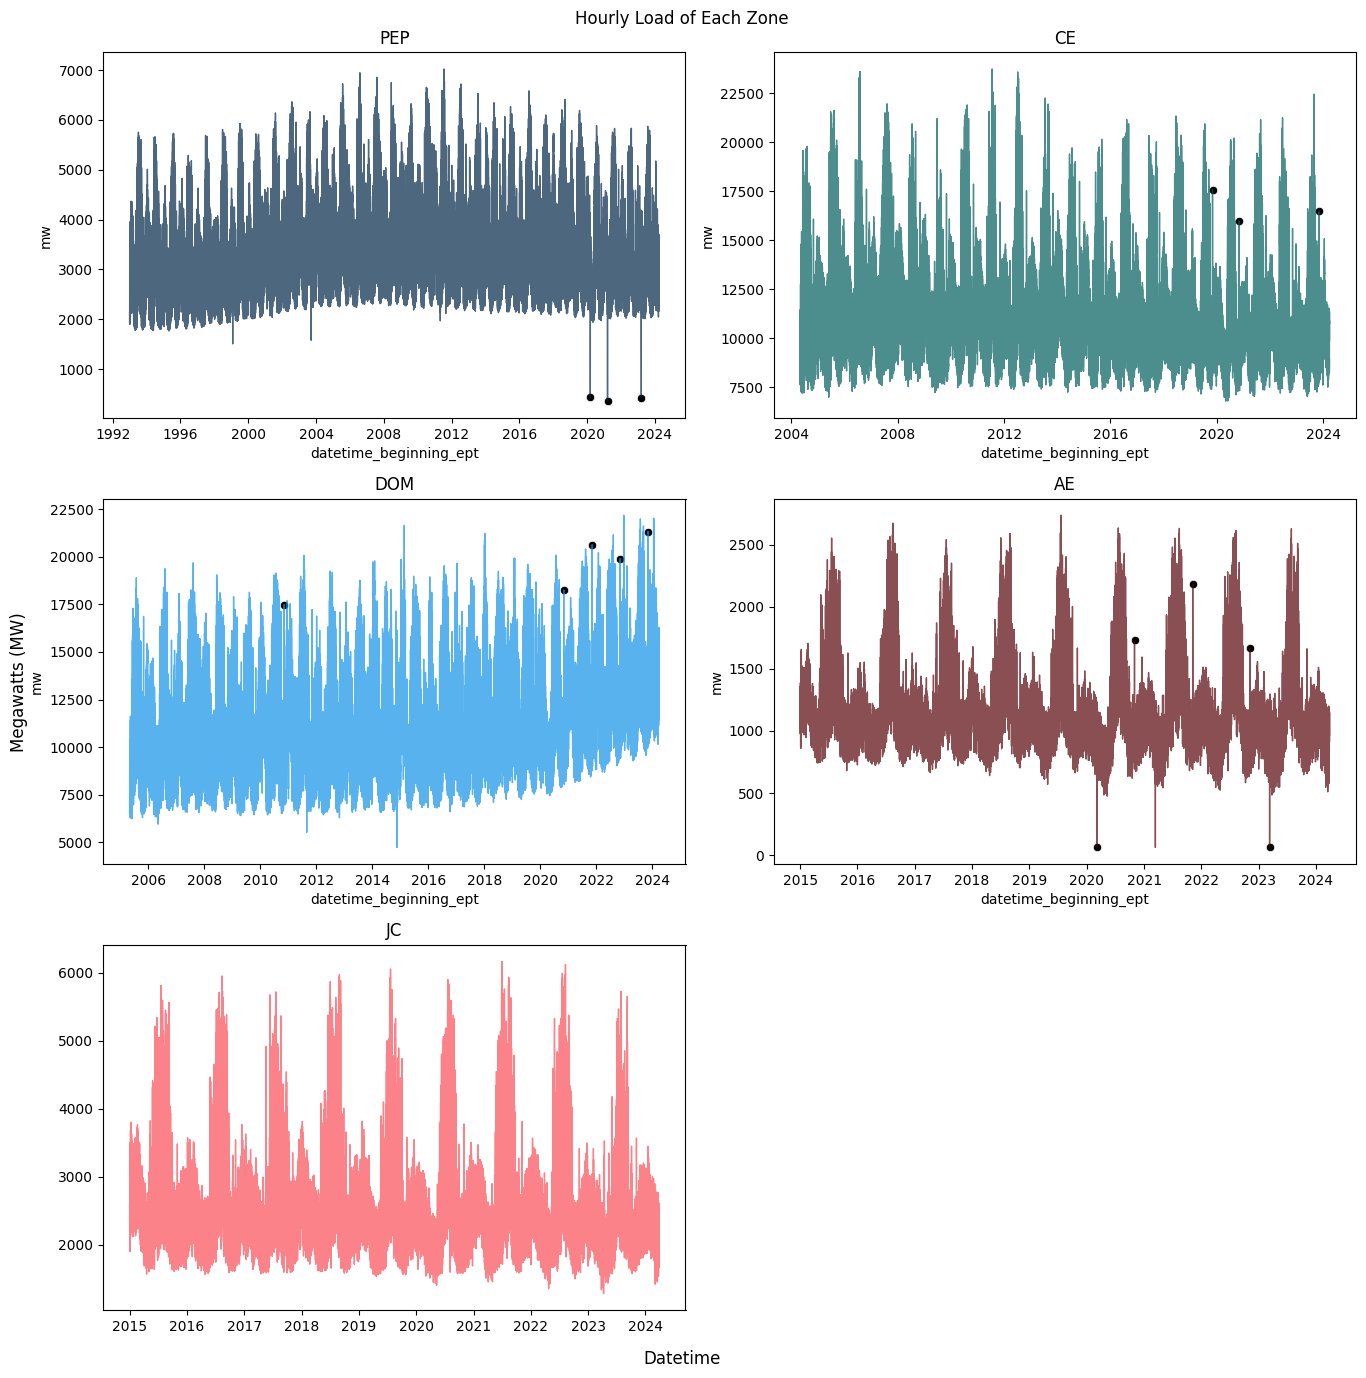

In [25]:
load_zone_plot(load_zone_df, outliers_index, figsize = (14,14), cmap = zones_palette)

The quantile method was chosen as it seemed to calibrate to a better result with this data.

Now to replace the found outliers with the median of the window that was stored earlier.

In [26]:
for zone in zones:
    display(load_zone_df.iloc[outliers_index.get(zone)])

load_zone_df.loc[replacement_medians.keys(), 'mw'] = list(replacement_medians.values())
    
# for zone, index in outliers_index.items():
#     load_zone_df.drop(outliers_index.get(zone), inplace = True)

,datetime_beginning_ept,zone,mw
598305,2020-03-08 01:00:00,AE,63.719
626861,2020-11-01 01:00:00,AE,1731.123
671381,2021-11-07 01:00:00,AE,2180.259
715061,2022-11-06 01:00:00,AE,1665.363
730185,2023-03-12 01:00:00,AE,68.317


,datetime_beginning_ept,zone,mw
583181,2019-11-03 01:00:00,CE,17586.314
626862,2020-11-01 01:00:00,CE,15989.914
758744,2023-11-05 01:00:00,CE,16491.537


,datetime_beginning_ept,zone,mw
261988,2010-11-07 01:00:00,DOM,17494.000
626863,2020-11-01 01:00:00,DOM,18249.653
671383,2021-11-07 01:00:00,DOM,20633.260
715063,2022-11-06 01:00:00,DOM,19902.046
758745,2023-11-05 01:00:00,DOM,21330.288


,datetime_beginning_ept,zone,mw


,datetime_beginning_ept,zone,mw
598301,2020-03-08 01:00:00,PEP,431.527
642824,2021-03-14 01:00:00,PEP,354.625
730181,2023-03-12 01:00:00,PEP,427.420


In [27]:
# To double-check that they were properly replaced.
# load_zone_df.loc[replacement_medians.keys()]

After reviewing the plot after outlier replacement, a few remaining data points were still there. Likely falling within the threshold because the previously removed outliers were skewing the distribution. The previous code could be altered to rerun and capture a second or third-wave but the remaining outliers could also just be captured by visuals and sorting the data.

The remainder will be manually removed for now and replaced with the median using the same process as before.

In [28]:
display(load_zone_df.loc[load_zone_df['zone'] == 'AE'].sort_values('mw', ascending = True).head(3))
display(load_zone_df.loc[load_zone_df['zone'] == 'PEP'].sort_values('mw', ascending = True).head(5))
display(load_zone_df.loc[load_zone_df['zone'] == 'DOM'].sort_values('mw', ascending = True).head(3))

outliers_manual = [642823, 642830, 53319, 93914, 93915, 93916, 367978,  598310, 730188, 93913, 93917, 93912]
manual_medians = []

for outlier in outliers_manual:
    zone = load_zone_df.loc[outlier]['zone']
    zone_df = load_zone_df.loc[load_zone_df['zone'] == zone]
    # Find min and max dates for that zone.
    date_min = zone_df['datetime_beginning_ept'].min()
    date_max = zone_df['datetime_beginning_ept'].max()
    # Create indow to calculate median.
    left = zone_df.loc[outlier]['datetime_beginning_ept'] - pd.Timedelta(days = 17)
    right = zone_df.loc[outlier]['datetime_beginning_ept'] + pd.Timedelta(days = 17)
    window_df = zone_df.loc[(zone_df['datetime_beginning_ept'].between(left, right, inclusive = 'both'))]
    w_median = window_df['mw'].median()

    manual_medians.append(round(w_median, 3))

load_zone_df.loc[outliers_manual, 'mw'] = manual_medians

,datetime_beginning_ept,zone,mw
642823,2021-03-14 01:00:00,AE,62.426
605926,2020-05-10 14:00:00,AE,475.194
605923,2020-05-10 13:00:00,AE,475.531


,datetime_beginning_ept,zone,mw
642830,2021-03-14 02:00:00,PEP,1406.669
53319,1999-01-31 15:00:00,PEP,1505.000
93914,2003-09-19 02:00:00,PEP,1578.554
93915,2003-09-19 03:00:00,PEP,1591.057
93916,2003-09-19 04:00:00,PEP,1609.728


,datetime_beginning_ept,zone,mw
367978,2014-11-18 03:00:00,DOM,4724.204
283165,2011-08-28 04:00:00,DOM,5516.000
283162,2011-08-28 03:00:00,DOM,5519.000


In [29]:
# Re-check
# load_zone_df.loc[outliers_manual]

Now to plot the results of the efforts.

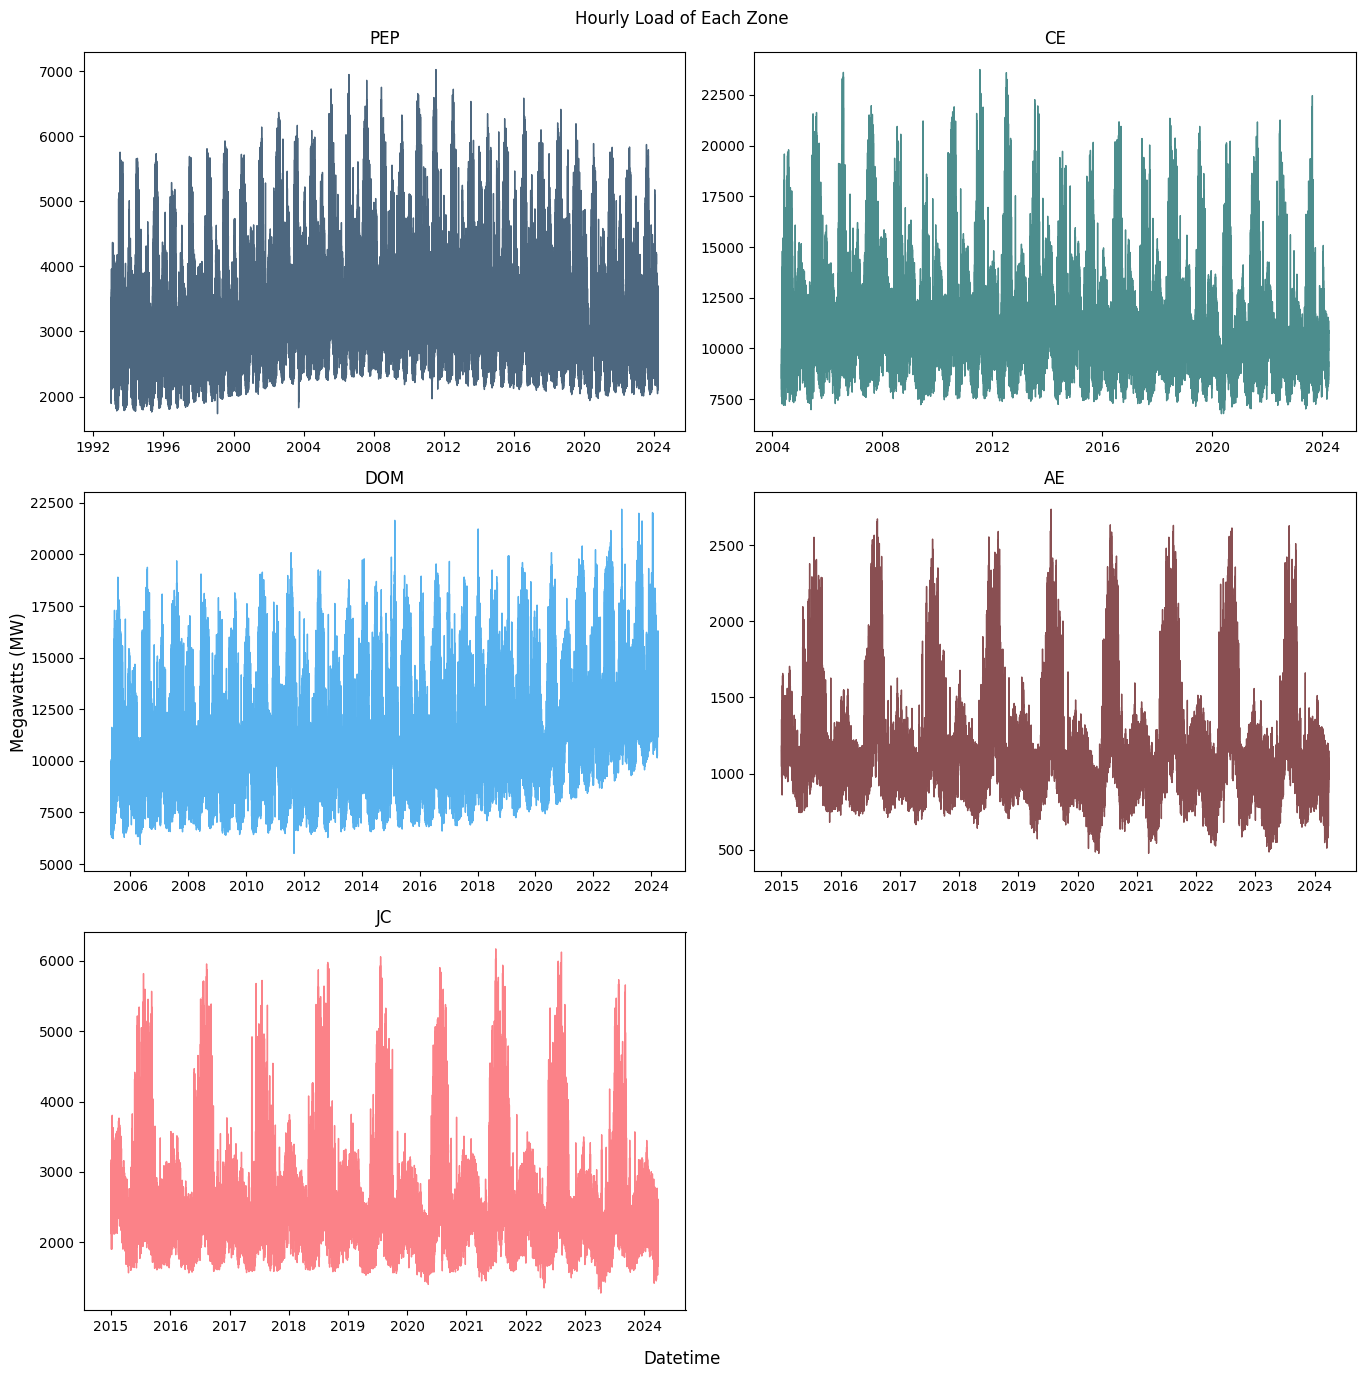

In [30]:
load_zone_plot(load_zone_df, figsize = (14,14), cmap = zones_palette)

Looks much better!

### 3.7. Joining Energy Load and Weather: <a name="merge"></a>

It is now time to join the datasets into one and duplicate the weather data to fit into the load dataset's hourly frequency.

In [31]:
load_zone_df.rename(columns = {'datetime_beginning_ept' : 'Date'}, inplace = True)
load_zone_df.reset_index(drop = True, inplace = True)

In [32]:
# Merge
load_df = load_zone_df.merge(weather_df, on = ['Date', 'zone'], how = 'left')

# Sort values by zone and date so we can use .ffill()
load_df.sort_values(by = ['zone', 'Date'], inplace = True)
display(load_df)

# Fill forward weather data up until next day.
load_df.ffill(inplace = True)
# Confirm fill worked.
display(load_df.tail(26))

,Date,zone,mw,MaxTemperature,MinTemperature,AvgTemperature,Precipitation
371136,2015-01-01 00:00:00,AE,1180.082,43.0,17.0,30.0,0.0
371143,2015-01-01 01:00:00,AE,1129.988,NaN,NaN,NaN,NaN
371149,2015-01-01 02:00:00,AE,1088.828,NaN,NaN,NaN,NaN
371151,2015-01-01 03:00:00,AE,1064.563,NaN,NaN,NaN,NaN
371157,2015-01-01 04:00:00,AE,1060.820,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
775991,2024-03-27 19:00:00,PEP,3202.078,NaN,NaN,NaN,NaN
776000,2024-03-27 20:00:00,PEP,3156.612,NaN,NaN,NaN,NaN
776005,2024-03-27 21:00:00,PEP,3035.994,NaN,NaN,NaN,NaN
776009,2024-03-27 22:00:00,PEP,2861.596,NaN,NaN,NaN,NaN


,Date,zone,mw,MaxTemperature,MinTemperature,AvgTemperature,Precipitation
775886,2024-03-26 22:00:00,PEP,2751.947,61.0,39.0,50.0,0.01
775895,2024-03-26 23:00:00,PEP,2608.338,61.0,39.0,50.0,0.01
775897,2024-03-27 00:00:00,PEP,2451.982,50.0,46.0,48.0,0.78
775905,2024-03-27 01:00:00,PEP,2363.249,50.0,46.0,48.0,0.78
775910,2024-03-27 02:00:00,PEP,2337.508,50.0,46.0,48.0,0.78
775912,2024-03-27 03:00:00,PEP,2339.010,50.0,46.0,48.0,0.78
775920,2024-03-27 04:00:00,PEP,2426.600,50.0,46.0,48.0,0.78
775922,2024-03-27 05:00:00,PEP,2626.287,50.0,46.0,48.0,0.78
775930,2024-03-27 06:00:00,PEP,2933.378,50.0,46.0,48.0,0.78
775932,2024-03-27 07:00:00,PEP,3149.023,50.0,46.0,48.0,0.78


As we can see, after joining the fill-forward method was used to fill in each hour of the same date with the same weather data, until the next day.

## 4. Feature Engineering <a name="feateng"></a>

---

Many of the upcoming models will benefit by adding additional features as exogenous covariates.

### 4.1. Date Features <a name="datefeat"></a>

Even though the data is a timeseries with a datetime feature, it is important to extract that data into separate categories as there is certainly multiple seasonalities within this dataset.

For example, each day the load oscillates as people move throughout the day, but also each season likely has its own effect. Separating these features is an important step in capturing the different seasonal periods in time series forecasting.

Hour, Day, Month, Year, and Day of Year (1-365) will all be extracted.

In [33]:
load_df['Hour'] = load_df['Date'].dt.hour
load_df['Day'] = load_df['Date'].dt.day_of_week
day_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
load_df['Month'] = load_df['Date'].dt.month
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
load_df['Year'] = load_df['Date'].dt.year
load_df['Day_of_Year'] = load_df['Date'].dt.day_of_year
load_df.head(3)

,Date,zone,mw,MaxTemperature,MinTemperature,AvgTemperature,Precipitation,Hour,Day,Month,Year,Day_of_Year
371136,2015-01-01 00:00:00,AE,1180.082,43.0,17.0,30.0,0.0,0,3,1,2015,1
371143,2015-01-01 01:00:00,AE,1129.988,43.0,17.0,30.0,0.0,1,3,1,2015,1
371149,2015-01-01 02:00:00,AE,1088.828,43.0,17.0,30.0,0.0,2,3,1,2015,1


### 4.2. Rolling Mean <a name="rollmean"></a>

Rolling mean is a very effecting feature and tool in time series forecasting. It smooths the signal, helping models find real trends.

Two rolling means will be added.
- Window of 3 data points.
- Window of 6 data points.

In [34]:
for zone in zones:
    mask = load_df['zone'] == zone
    temp_df = load_df.loc[mask]
    # 3 Hour Window
    load_df.loc[mask, 'Rolling_Mean_3'] = load_df[mask]['mw'].rolling(3).mean()
    # 6 Hour Window
    load_df.loc[mask, 'Rolling_Mean_6'] = load_df[mask]['mw'].rolling(6).mean()

### 4.3. Lagged Features <a name="lag"></a>

Lag of the target variable, `MW`, at different intervals. 

For example, a lag of 24 is the same hour but yesterday's `MW`. This helps identify trends that have seasonality of that chosen lag value.

Lags of 1, 6, 24, 24 * 7 (1 Week), 24 * 30 (1 Month) will be included. 

All the way up to a year would be useful, however, it creates rows with empty NaN values the same size of the lag because it has to start that far into the future. These rows will have to be removed as some of the models cannot handle NaNs/no values.

*Note: Autocorrelation Functions (ACF) and Partial Autocorrelation Functions (PACF) are great tools to plot and identify which lags have significant correlation in the data. These will be analyzed later on in the SARIMAX model section and might alter what is done in this cell.*

In [35]:
# Lag Features
# Create mask for each zone since shift uses index and
# needs to reset shift at each zone.

for zone in zones:
    mask = load_df['zone'] == zone
    temp_df = load_df.loc[mask]
    # 1 Hour
    load_df.loc[mask, 'Lag_Hour'] = load_df[mask]['mw'].shift(1)
    # 6 Hours
    load_df.loc[mask, 'Lag_6_Hours'] = load_df[mask]['mw'].shift(6)
    # 24 Hours
    load_df.loc[mask, 'Lag_Day'] = load_df[mask]['mw'].shift(24)
    # 1 Week
    load_df.loc[mask, 'Lag_Week'] = load_df[mask]['mw'].shift(24*7)
    # 1 Month
    load_df.loc[mask, 'Lag_Month'] = load_df[mask]['mw'].shift(24*30)
    # 1 Year
    # load_df.loc[mask, 'Lag_Year'] = load_df[mask]['mw'].shift(24*365)

display(load_df.head(2))
display(load_df.tail(2))

,Date,zone,mw,MaxTemperature,MinTemperature,AvgTemperature,Precipitation,Hour,Day,Month,Year,Day_of_Year,Rolling_Mean_3,Rolling_Mean_6,Lag_Hour,Lag_6_Hours,Lag_Day,Lag_Week,Lag_Month
371136,2015-01-01 00:00:00,AE,1180.082,43.0,17.0,30.0,0.0,0,3,1,2015,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371143,2015-01-01 01:00:00,AE,1129.988,43.0,17.0,30.0,0.0,1,3,1,2015,1,NaN,NaN,1180.082,NaN,NaN,NaN,NaN


,Date,zone,mw,MaxTemperature,MinTemperature,AvgTemperature,Precipitation,Hour,Day,Month,Year,Day_of_Year,Rolling_Mean_3,Rolling_Mean_6,Lag_Hour,Lag_6_Hours,Lag_Day,Lag_Week,Lag_Month
776009,2024-03-27 22:00:00,PEP,2861.596,50.0,46.0,48.0,0.78,22,2,3,2024,87,3018.067333,3110.431833,3035.994,3205.710,2751.947,2840.826,2787.267
776015,2024-03-27 23:00:00,PEP,2698.059,50.0,46.0,48.0,0.78,23,2,3,2024,87,2865.216333,3024.024333,2861.596,3216.504,2608.338,2710.910,2601.164


### 4.4. Fourier Transform <a name="fft"></a>

Fourier transforms are incredibly powerful at decomposing signals, in this instance helping identify and separate seasonal periodicity. 

By taking a Fast Fourier Transform (FFT) we can then calculate the spectral density and analyze the frequencies that are important in our data. This information alone is useful as a feature and can be used directly as it will give seasonal periods high magnitude values at their peaks, but also will guide some other aspects of this project by identifying all potential seasonality periods.

*Note this is a huge subject so it won't be tackled here but fourier transform terms can also be used to extend some models that are only designed to capture one seasonal period into capturing multiples.*

In [36]:
for zone in zones:
    mask = load_df['zone'] == zone
    temp_df = load_df.loc[mask]
    # Perform fast fourier transform and take abs() to get spectral density.
    load_df.loc[mask, 'FFT'] = np.abs(fft(temp_df['mw'].values)) ** 2
    # Assign sample rate and find frequencies for plot.
    # d is sample rate. 1 = samples / hour.
    load_df.loc[mask, 'FFT_Freq'] = np.fft.fftfreq(temp_df['mw'].size, d = 1)

load_df.tail(2)

,Date,zone,mw,MaxTemperature,MinTemperature,AvgTemperature,Precipitation,Hour,Day,Month,...,Day_of_Year,Rolling_Mean_3,Rolling_Mean_6,Lag_Hour,Lag_6_Hours,Lag_Day,Lag_Week,Lag_Month,FFT,FFT_Freq
776009,2024-03-27 22:00:00,PEP,2861.596,50.0,46.0,48.0,0.78,22,2,3,...,87,3018.067333,3110.431833,3035.994,3205.710,2751.947,2840.826,2787.267,8.072594e+13,-0.000007
776015,2024-03-27 23:00:00,PEP,2698.059,50.0,46.0,48.0,0.78,23,2,3,...,87,2865.216333,3024.024333,2861.596,3216.504,2608.338,2710.910,2601.164,1.734200e+15,-0.000004


You can use the frequency axis to find the corresponding periods by taking the reciprocal of the frequency (period = 1 / frequency) which was assigned above in `np.fft.fftfreq()` with `d = `. 

For example, if you find a peak at frequency f, the corresponding period would be `1/f`. This will be used to identify seasonal periods, but for better interpretability `f` will be multiplied by 24 to change the sample unit to days.

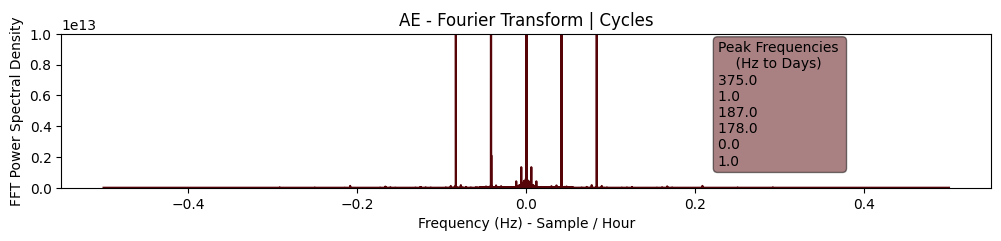

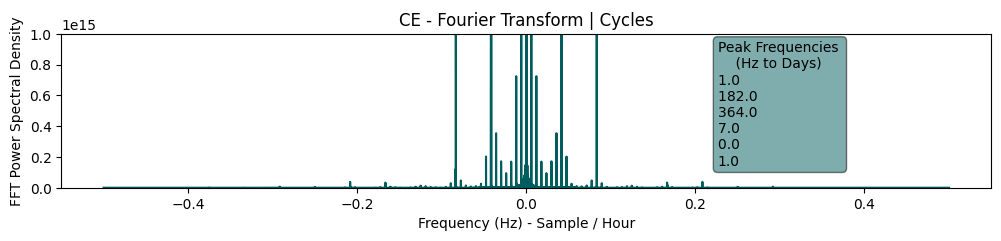

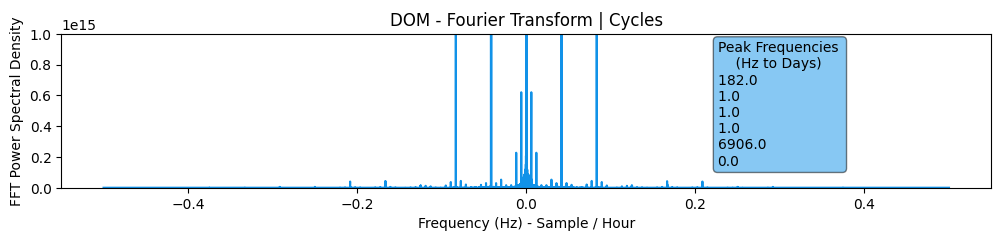

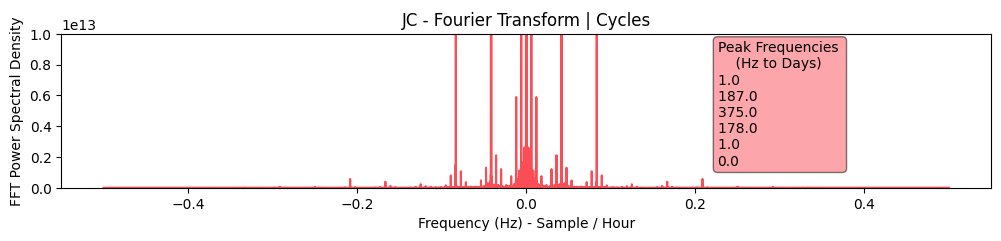

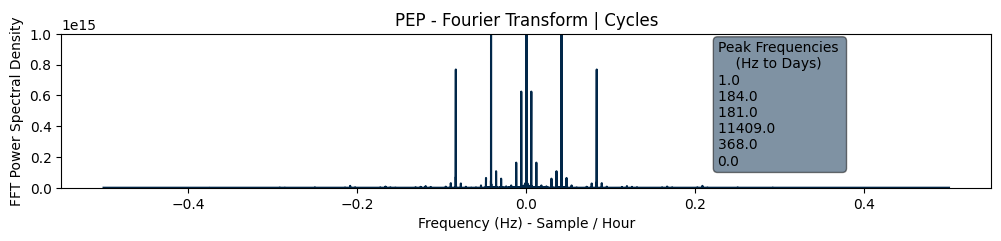

In [37]:
for zone in zones:
    plt.subplots(figsize = (12,2))
    sns.lineplot(load_df.loc[load_df['zone'] == zone], y = 'FFT', x = 'FFT_Freq', c = zones_palette[zone])
    # Assign y limits based on zone to better visualize.
    if zone in ['AE', 'JC']:
        plt.ylim(bottom = 0, top = 10000000000000)
    else:
        plt.ylim(bottom = 0, top = 1000000000000000)
    # plt.xlim(left = 0) # Negatives are redundant.
    plt.xlabel('Frequency (Hz) - Sample / Hour')
    plt.ylabel('FFT Power Spectral Density')
    plt.title(f'{zone} - Fourier Transform | Cycles')

    # List top repeating cycles.
    # Find top FFT values.
    top_freq = load_df.loc[load_df['zone'] == zone]['FFT'].sort_values(ascending = False).index[1:13:2]
    # Transform frequency to period of 1 day for interpretability
    top_cycle_days = list(np.round(1 / (np.abs(load_df.loc[top_freq]['FFT_Freq'].astype(float))*24)))
    text_box = ['\n' + (str(x)) for x in top_cycle_days]
    plt.text(x = 0.5, y = -0.02, 
             s= f"Peak Frequencies \n    (Hz to Days) {' '.join(text_box)}", 
             transform = ax.transAxes,
             bbox = dict(facecolor = zones_palette[zone], edgecolor = 'black', boxstyle = 'round', alpha = 0.5))

    plt.show()

Scales were adjusted on this graph heavily to get a better picture and may vary between zones even as they have different magnitudes.

We can see most of the different zones share peak magnitude frequencies at approximately:
- ~182 Days (Roughly 6 Months)
- ~365 Days (1 Year)
- ~1 Day

These represent the strongest seasonal periods in the time series data.

*Some values are duplicated because they are adjacent frequencies that were rounded.*

### 4.5. First and Second-Order Derivatives <a name="derivatives"></a>

Sometimes called discrete derivatives or differencing, this method is analogous to derivatives but using discrete time series data. You often see this used as a standard metric financial/economic settings.

- **First-Order:** Gives the instantaneous rate of change between the samples, identifying both the direction and magnitude.
- **Second-Order:** Identifies the acceleration of the rate of change which can be useful in finding inflection points in time series data.

In [38]:
for zone in zones:
    mask = load_df['zone'] == zone
    temp_df = load_df.loc[mask]
    # 1st Order
    load_df.loc[mask, 'Deriv_1'] = load_df[mask]['mw'].diff()
    # 2nd Order
    load_df.loc[mask, 'Deriv_2'] = load_df[mask]['mw'].diff().diff()

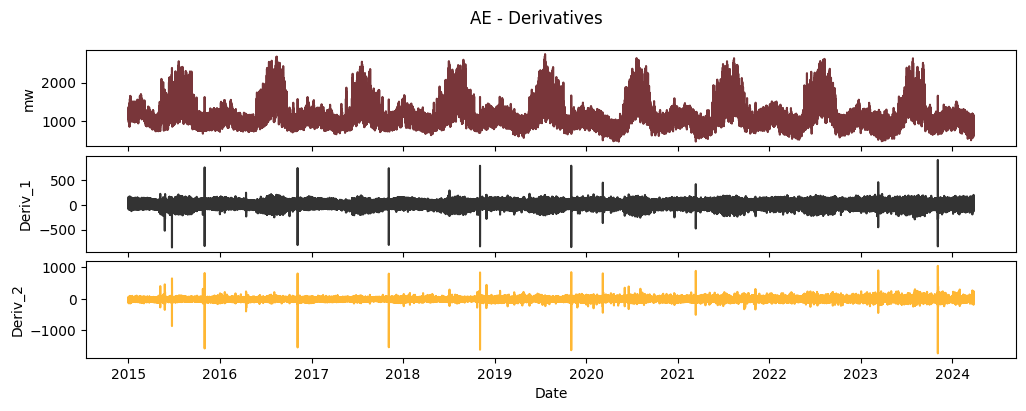

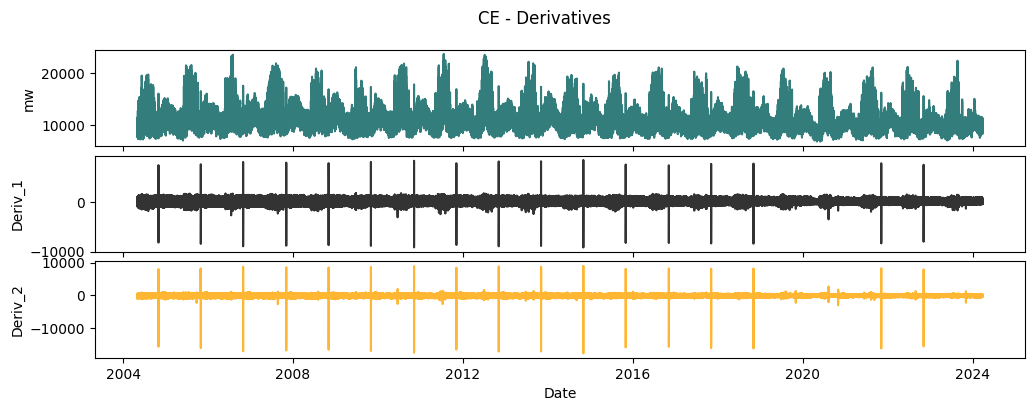

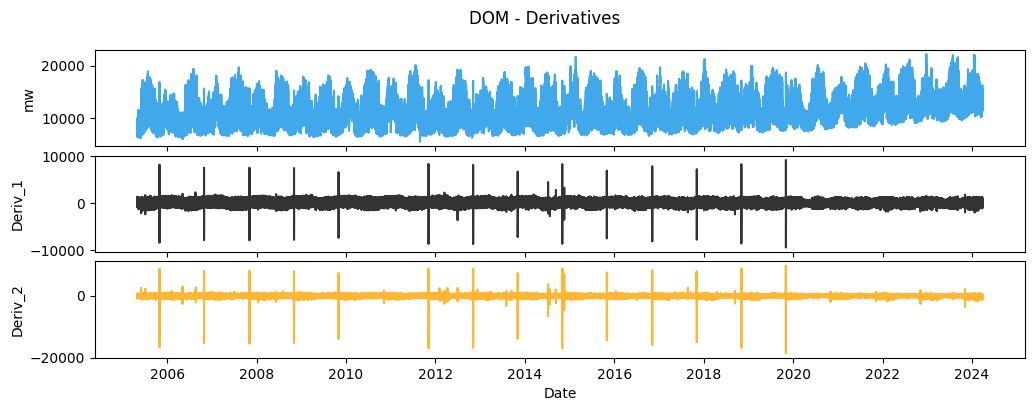

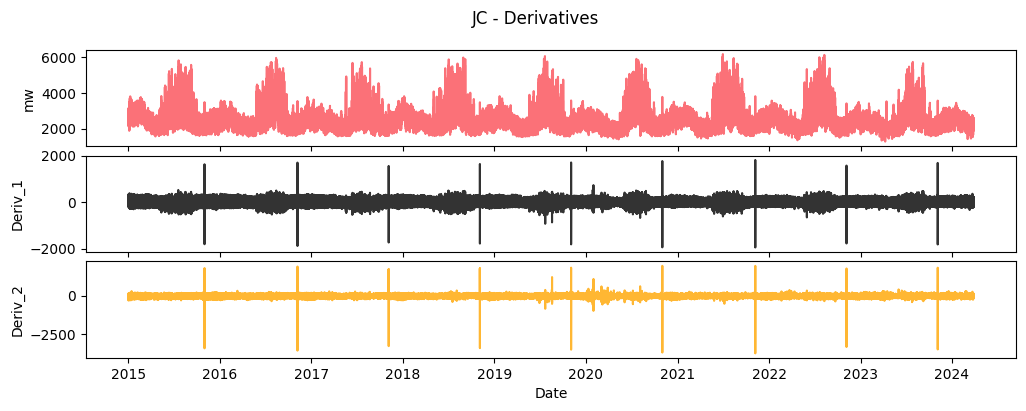

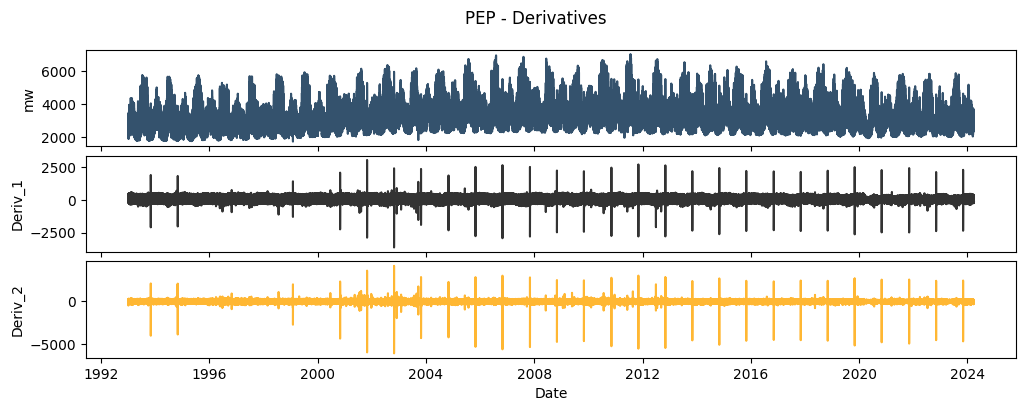

In [39]:
for zone in zones:
    fig, ax = plt.subplots(3,1, figsize = (12,4), sharey = False, sharex = True)
    sns.lineplot(load_df.loc[load_df['zone'] == zone], ax = ax[0], y = 'mw', x = 'Date', c = zones_palette[zone], alpha = 0.8)
    sns.lineplot(load_df.loc[load_df['zone'] == zone], ax = ax[1], y = 'Deriv_1', x = 'Date', c = 'black', alpha = 0.8)
    sns.lineplot(load_df.loc[load_df['zone'] == zone], ax = ax[2], y = 'Deriv_2', x = 'Date', c = 'orange', alpha = 0.8)
    fig.suptitle(f"{zone} - Derivatives")
    fig.subplots_adjust(hspace = 0.1)

## 5. Exploratory Data Analysis (EDA) <a name="eda"></a>

---


In [40]:
def plot_daterange(date_min, date_max, zone_select):
    """Plots MW vs Date in given date range and zone. Interval starts and ends at midnight.
    Note: Some of the text positions break down with larger ranges.
    Ideal range is two-weeks.

    Parameters:
        date_min (string): Date of beginning of interval (inclusive).
        date_max (string): Date of end of interval (inclusive).
        zone_select (string): Zone from load_zone_df to plot.
    
    Returns:
        None. Prints plot to output."""
    
    date_min = pd.to_datetime(f'{date_min} 00:00:00')
    date_max = pd.to_datetime(f'{date_max} 00:00:00')
    date_range = (date_max - date_min).days
    weather_temp = weather_df.loc[(weather_df['Date'].between(date_min, date_max, inclusive='both')) & 
                                (weather_df['zone'] == zone_select)].reset_index(drop = True)

    
    plt.subplots(figsize = (14, 8))
    sns.lineplot(load_zone_df.loc[(load_zone_df['Date'].between(date_min, date_max, inclusive='both')) & 
                                    (load_zone_df['zone'] == zone_select)], 
                    x = 'Date', 
                    y = 'mw',
                    c = zones_palette[zone_select],  
                    alpha = 0.7, lw = 1, marker = 'o')

    # Iterates through each day in range.
    for i in range(date_range + 1):
        # Day separating line.
        plt.axvline(date_min + pd.Timedelta(days = i), color = 'purple', ls = '--')
        if i > date_range-1:
            continue
        # Day of the week.
        plt.text(x = date_min + pd.Timedelta(days = i) + pd.Timedelta(hours = 10),
                    y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
                    s = f'{(date_min + pd.Timedelta(days = i)).day_name()}',
                    rotation = 'vertical',
                    weight='bold',
                    alpha = 0.75)
        # Temperatures.
        # High
        plt.text(x = date_min + pd.Timedelta(days = i) + pd.Timedelta(hours = 6),
                    y = ((plt.ylim()[0] + plt.ylim()[1]) / 2) + ((plt.ylim()[0] + plt.ylim()[1]) / 8),
                    s = f"Hi:{weather_temp['MaxTemperature'].iloc[i]}\N{DEGREE SIGN}",
                    rotation = 'horizontal',
                    alpha = 0.75)
        # Low
        plt.text(x = date_min + pd.Timedelta(days = i) + pd.Timedelta(hours = 6),
                    y = ((plt.ylim()[0] + plt.ylim()[1]) / 2) - ((plt.ylim()[0] + plt.ylim()[1]) / 8),
                    s = f"Lo:{weather_temp['MinTemperature'].iloc[i]}\N{DEGREE SIGN}",
                    rotation = 'horizontal',
                    alpha = 0.75)
    return None

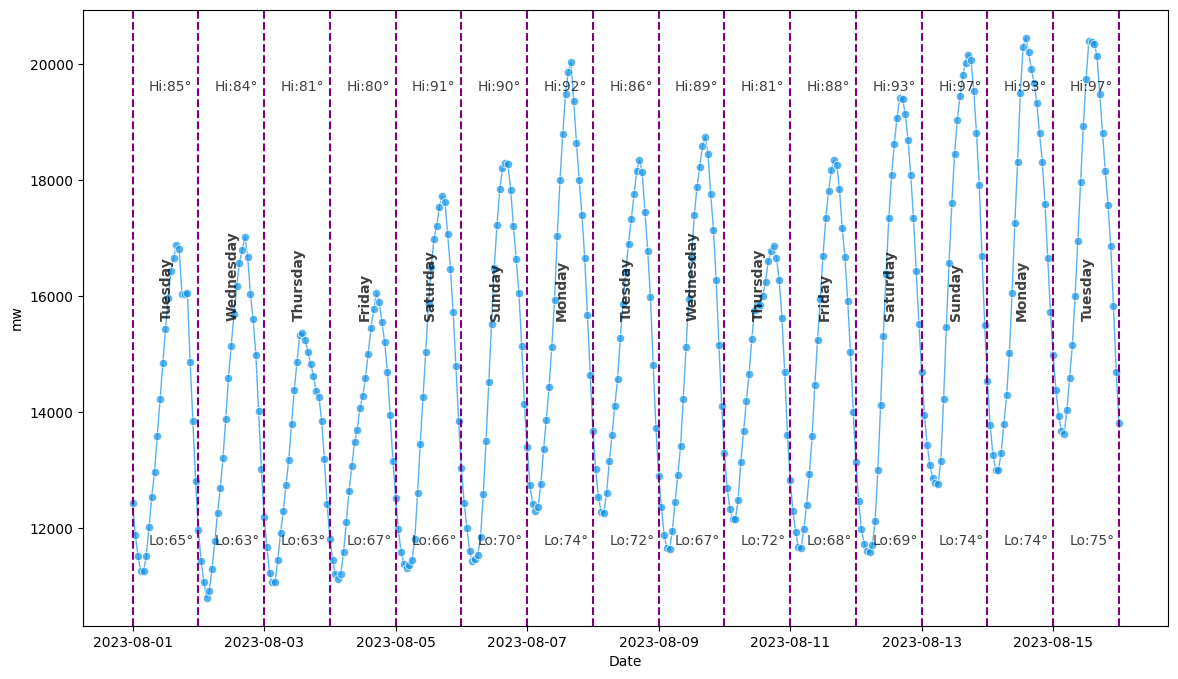

In [41]:
plot_daterange('8/01/2023', '8/16/2023', 'DOM')

This is about as expected, load is lowest at night and rises throughout the day. Data is from August on the East Coast of the US which tends to be their hottest month.

Things to note:

- We can see a likely positive correlation between temperature and load rising in tandem.
- I would assume weekends have lower energy loads but it is unclear on this graph, likely due to the temperature's effect.

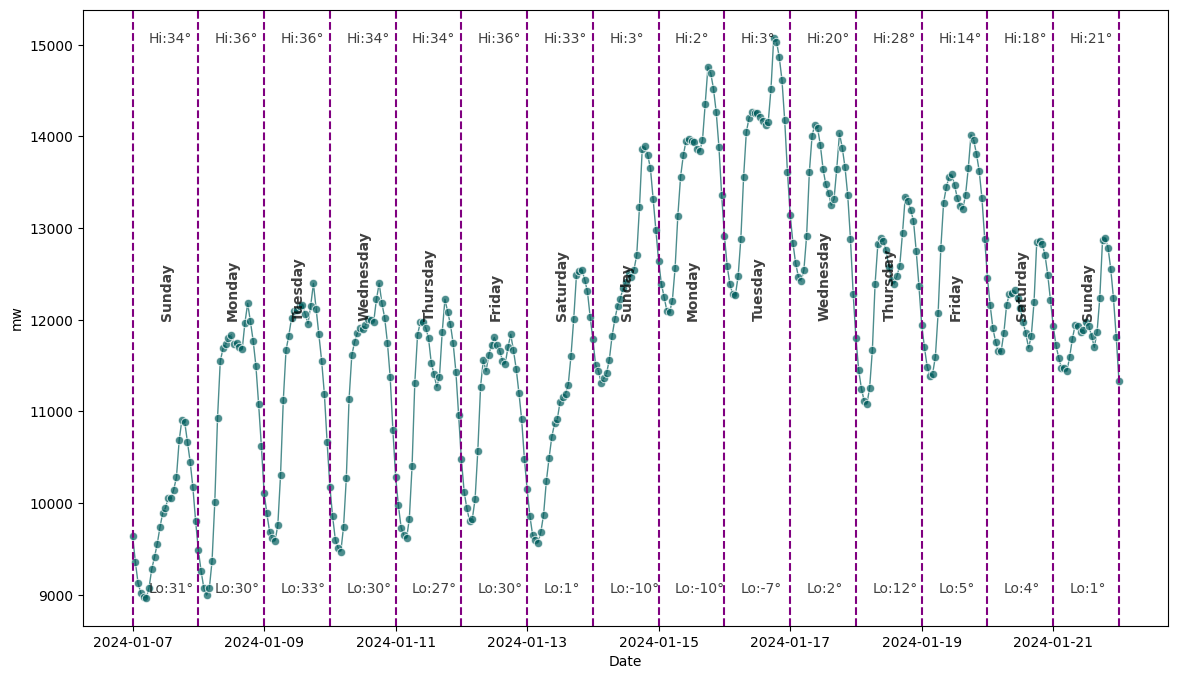

In [42]:
plot_daterange('01/07/2024', '01/22/2024', 'CE')

In contrast to the last plot, this is data from Chicago in one of the coldest months, January.

- Saturday and Sunday do tend to be lower than the weekdays.
- Temperature once again is showing itself to be a very important covariate, making load rise on 2024-1-14 when high temperatures drop from 33 to 3.

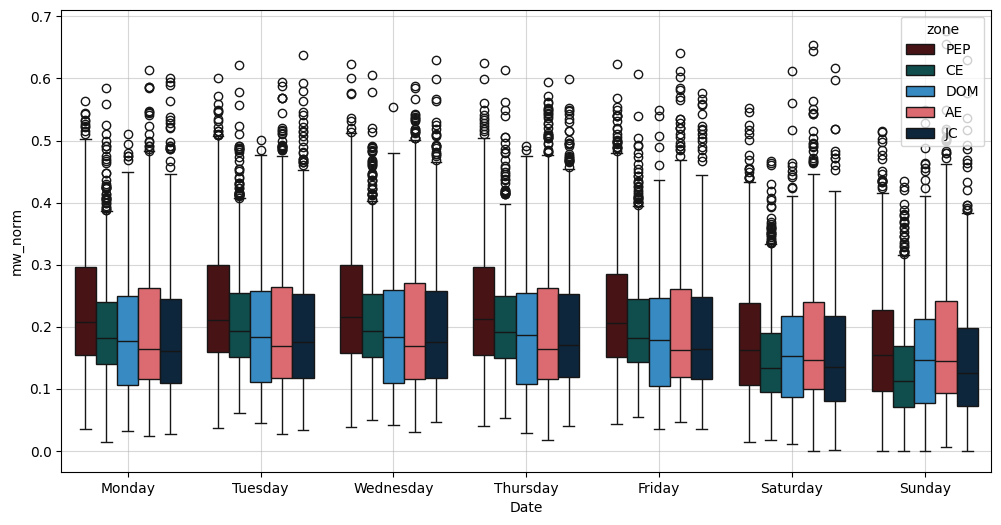

In [43]:
load_day_df = load_zone_df.copy(deep = True)
load_day_df['Date'] = pd.to_datetime(load_day_df['Date'].dt.date)
load_day_df = load_day_df.groupby(['Date', 'zone'], as_index = False).sum()

#load_day_df['mw_norm'] = float
for zone in zones:
    mask = load_day_df['zone'] == zone
    temp_df = load_day_df.loc[mask]
    min_mw = temp_df['mw'].min()
    max_mw = temp_df['mw'].max()
    load_day_df.loc[mask, 'mw_norm'] = (temp_df['mw'] - min_mw) / max_mw

palette = ['#570408', '#005d5d', '#1192e8', '#fa4d56', '#012749']
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.subplots(figsize = (12, 6))
sns.boxplot(load_day_df, 
                x = (load_day_df['Date'].dt.day_name()), 
                y = load_day_df['mw_norm'],
                hue = 'zone',
                order = order,
                palette = sns.color_palette(palette, 5),
                saturation = 0.65)
plt.grid(alpha = 0.5)

Saturday and Sunday do seem to be lower but not by a significant amount.

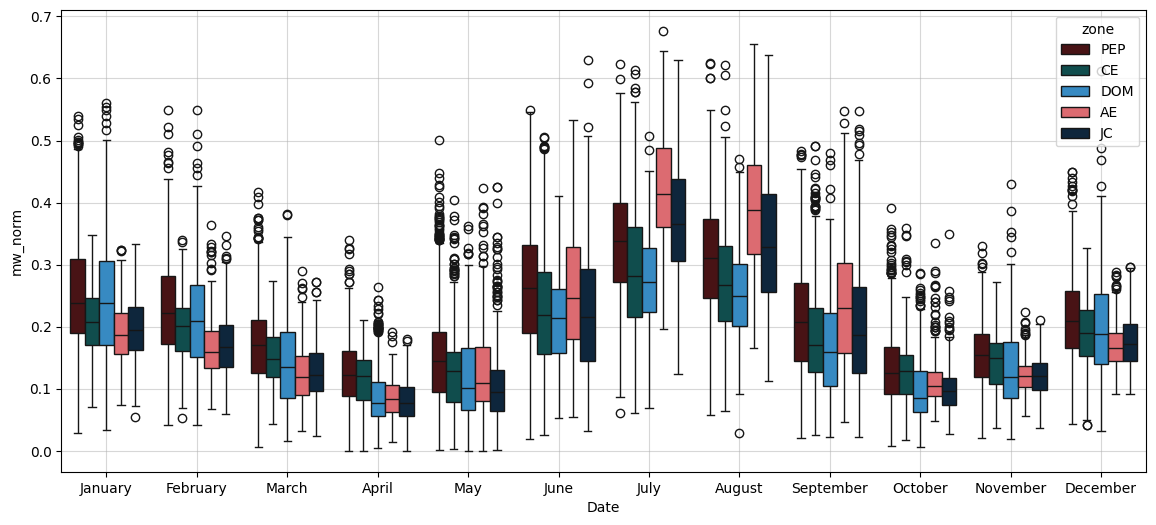

In [44]:
# Month
plt.subplots(figsize = (14, 6))
sns.boxplot(load_day_df, 
                x = (load_day_df['Date'].dt.month_name()), 
                y = load_day_df['mw_norm'],
                hue = 'zone',
                palette = sns.color_palette(palette, 5),
                saturation = 0.65)
plt.grid(alpha = 0.5)

Summer months not only have the most variance but also highest load demands.

## 6. Train, Validation, and Test Split<a name="split"></a>

---

To avoid data leakage the test set will always be assigned the most recent dates with zero overlap in train or validation sets.

Since each zone has different beginning dates but share the same end dates this can be used to split each zone in the same way. 

***Important Note:*** In a decision-making setting, this split should have occurred before the EDA section to avoid data-leakage/snooping. This was not done in this case as this is just an exercise.

In [45]:
# Train - Min up to 2021
# Val - 2021 up to 2023
# Test - 2023 to Max
train_cutoff = '1/1/2019'
test_cutoff = '1/1/2022'

train = {}
val = {}
test = {}
for zone in zones:
    train[zone] = []
    val[zone] = []
    test[zone] = []
    train[zone] = load_df.loc[(load_df['zone'] == zone) & 
                              (load_df['Date'] < pd.to_datetime(train_cutoff))]

    val[zone] = load_df.loc[(load_df['zone'] == zone) & 
                            (load_df['Date'] >= pd.to_datetime(train_cutoff)) & 
                            (load_df['Date'] < pd.to_datetime(test_cutoff))]
    
    test[zone] = load_df.loc[(load_df['zone'] == zone) & 
                             (load_df['Date'] >= pd.to_datetime(test_cutoff))]
    
    # Drop rows with NaN created from feature engineering.
    train[zone] = train[zone][~train[zone].isnull().any(axis = 1)]

Because of the way a few models work, the leap year in the validation set was causing issues. It will be removed here for now until another solution is worked on. Either way it shouldn't have much importance to the results.

In [46]:
# Leap year in validation causing issues in seasonal naive model.
# Removing for now.
for zone in zones:
    leap_year_idx = val[zone].loc[val[zone]['Date'].between('2020-02-29 00:00:00',
                                                            '2020-02-29 23:00:00', 
                                                            inclusive = 'both')].index
    val[zone].drop(leap_year_idx, inplace = True)

/var/folders/m8/939h_p3x6fq4_c0w_pfktz840000gn/T/ipykernel_43419/2023956526.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val[zone].drop(leap_year_idx, inplace = True)


Sets will be placed into dictionaries keyed by zone name, so models can iterate through each zone and fit/predict separately.

In [47]:
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}

for zone in zones:
        X_train[zone], X_val[zone], X_test[zone] = [], [], []
        y_train[zone], y_val[zone], y_test[zone] = [], [], []
        # Train
        X_train[zone] = train[zone].set_index('Date')
        y_train[zone] = X_train[zone]['mw']
        X_train[zone] = X_train[zone].iloc[:, 2:]
        # Validation
        X_val[zone] = val[zone].set_index('Date')
        y_val[zone] = X_val[zone]['mw']
        X_val[zone] = X_val[zone].iloc[:, 2:]
        # Test
        X_test[zone] = test[zone].set_index('Date')
        y_test[zone] = X_test[zone]['mw']
        X_test[zone] = X_test[zone].iloc[:, 2:]

Now, plot the split regions for reference. 

*Note:* 
- This might be revisited in the future to prune some of the training data of the longer existing zones for better comparability between zones.
- The location of the COVID lockdown period might be an outlier to note in this dataset as it might affect model performance depending on which region it ends up in.
    - We could add a static categorical feature denoting a hot-encoding of holidays and perhaps COVID to account for this.

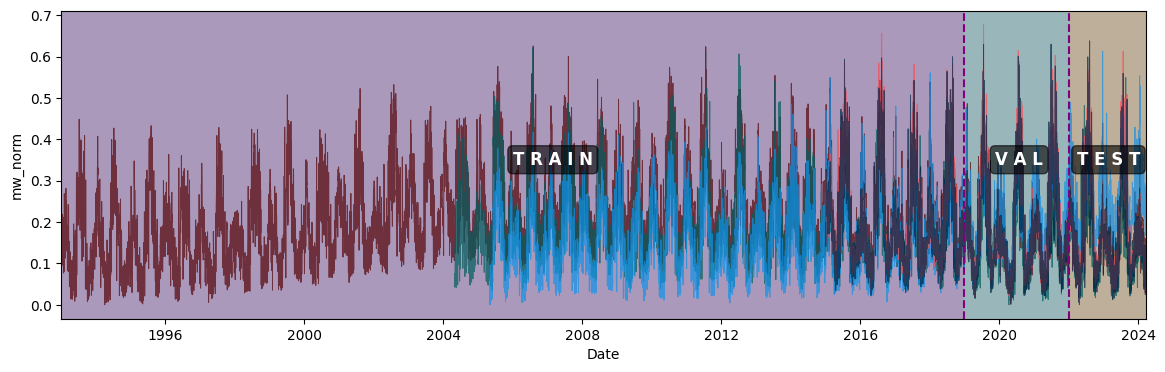

In [48]:
def set_region_overlay(set_label, start_date, end_date, x_offset):
    mid_date_train = (list(pd.date_range(start = pd.to_datetime(start_date), end = pd.to_datetime(end_date))))
    plt.text(x = mid_date_train[int(len(mid_date_train) / 2) + x_offset],
                y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
                s = set_label,
                rotation = 'horizontal',
                weight = 'extra bold',
                fontsize = 'large',
                antialiased = True,
                alpha = 1,
                c = 'white',
                bbox = dict(facecolor = 'black', edgecolor = 'black', boxstyle = 'round', alpha = 0.6))
    return None

plt.subplots(figsize = (14,4))
sns.lineplot(load_day_df, x = 'Date', y = 'mw_norm', hue = 'zone', palette=sns.color_palette(palette, 5), lw = 0.7, alpha = 0.7)
plt.margins(x = 0)
plt.axvline(pd.to_datetime(train_cutoff), color = 'purple', ls = '--')
plt.axvline(pd.to_datetime(test_cutoff), color = 'purple', ls = '--')

plt.axvspan(load_day_df['Date'].min(), pd.to_datetime(train_cutoff), facecolor='#2b0054', alpha = 0.4)
plt.axvspan(pd.to_datetime(train_cutoff), pd.to_datetime(test_cutoff), facecolor='#004a54', alpha = 0.4)
plt.axvspan(pd.to_datetime(test_cutoff), load_day_df['Date'].max(), facecolor='#5e3904', alpha = 0.4)

set_region_overlay('T R A I N', load_day_df['Date'].min(), train_cutoff, 0)
set_region_overlay('V A L', train_cutoff, test_cutoff, -225)
set_region_overlay('T E S T', train_cutoff, load_day_df['Date'].max(), 225)

plt.legend().remove()
plt.show()

## 7. Model Setup <a name="model"></a>

---


In [49]:
horizon_selector = {'1H' : pd.Timedelta(hours = 0),
            '3D' : pd.Timedelta(hours = (24*3)-1),
            '1W' : pd.Timedelta(hours = (24*7)-1),
            '6M' : pd.Timedelta(hours = (24*181)-1),
            '1Y' : pd.Timedelta(hours = (24*365)-1),
            '2Y' : pd.Timedelta(hours = (24*365*2)-1)}

In [50]:
def generate_y_test_horizon(zone, forecast_horizon):
    """Generates slice of test set according to input zone and forecast window.
    
    Parameters:
        zone (string): String of zone data to retrieve.
        forecast_horizon (string): 1H, 3D, 1W, 6M, 1Y, 2Y which will slice test up to that amount of time.
    Returns:
        Numpy Array of test[zone] interval up to the forecast window."""
    horizon_selector = {'1H' : pd.Timedelta(hours = 0),
                '3D' : pd.Timedelta(hours = (24*3)-1),
                '1W' : pd.Timedelta(hours = (24*7)-1),
                '6M' : pd.Timedelta(hours = (24*181)-1),
                '1Y' : pd.Timedelta(hours = (24*365)-1),
                '2Y' : pd.Timedelta(hours = (24*365*2)-1)}
    if forecast_horizon not in horizon_selector:
        raise Exception('That forecast window is not supported, please choose one of the following: 1H, 3D, 1W, 6M, 1Y, 2Y.')

    date_min = test[zone]['Date'].min()
    y_test = test[zone].loc[test[zone]['Date'].between(date_min, 
                                                   date_min + horizon_selector[forecast_horizon], 
                                                   inclusive = 'both')]['mw'].to_numpy()
    return y_test

### 7.1. Baseline Models <a name="baseline"></a>

#### 7.1.1 Seasonal Naive Forecasting <a name="seasonalnaive"></a>

The Seasonal Naive Forecasting Model is a simple but often effective baseline model. It will be setup here for different forecast horizons from which all other models will be measured against.

This model forecasts future values to be equal to past values of the target variable (`MW`) shifted backwards one period of the input season. As we predict different forecast horizons, the length of the horizon can be used as a seasonal-lag to adjust the naive forecast lengths. 

**For example:**

If we want to forecast a week into the future, the previously observed values from the same week last year will be used as the forecast.

*Note:*

Since the validation set will not be necessary in these baseline models, they are being utilized here instead of train since the validation set contains the last observed values of the last seasonal period.

In [51]:
# TODO: Generalize this section better. Handle all horizons and generalize y_pred method.
# Find date for each forecast window (corresponding date in validate forecast_window)
naive_date = {'1H' : (val[zone]['Date'].max() + pd.Timedelta(hours = 1)) - pd.Timedelta(days = 365),
              '3D' : (val[zone]['Date'].max() + pd.Timedelta(hours = 24*3)) - pd.Timedelta(days = 365),
              '1W' : (val[zone]['Date'].max() + pd.Timedelta(hours = 24*7)) - pd.Timedelta(days = 365),
              '6M' : (val[zone]['Date'].max() + pd.Timedelta(hours = 24*181)) - pd.Timedelta(days = 365),
              '1Y' : (val[zone]['Date'].max()),
              '2Y' : (val[zone]['Date'].max())}

# Initialize prediction dictionary - {zone : {horizon : y_pred}}
naive = {}

for zone in zones:
    naive[zone] = {}
    for horizon in horizon_selector:
        naive[zone][horizon] = []
        # 1H and 2Y have different methods currently.
        if horizon == '1H':
            naive[zone][horizon] = val[zone].loc[val[zone]['Date'] == naive_date[horizon]]['mw'].to_numpy()
            continue
        if horizon == '2Y':
            naive[zone][horizon] = val[zone].loc[val[zone]['Date'].between(naive_date['1H'] - pd.Timedelta(days = 366),
                                                                            naive_date[horizon], inclusive = 'both')]['mw'].to_numpy()
            continue
        # Create naive predictions (y_pred) of 1 Hour, 3 Day, 1 Week, 6 Months, 1 Year, and 2 Years forecast windows.
        naive[zone][horizon] = val[zone].loc[val[zone]['Date'].between(naive_date['1H'], 
                                                                       naive_date[horizon], inclusive = 'both')]['mw'].to_numpy()

In [52]:
display(naive['AE']['1H'])

array([1023.045])

In [53]:
print(len(naive['AE']['6M'])/(365*24))
print(len(naive['AE']['1Y'])/(365*24))
print(len(naive['AE']['2Y'])/(365*24))

0.4958904109589041
1.0
2.0


#### 7.1.2 Standard Deviation <a name="std"></a>

In [54]:
# Standard Deviation of the test forecast horizon as a baseline metric.
sigma = {}
for zone in zones:
    sigma[zone] = {}
    for horizon in horizon_selector:
        sigma[zone][horizon] = []
        y_test_horizon = generate_y_test_horizon(zone, horizon)
        sigma[zone][horizon] = y_test_horizon.std()

In [55]:
sigma['AE']

{'1H': 0.0,
 '3D': 174.05554505913219,
 '1W': 168.31031074690557,
 '6M': 235.76537476014644,
 '1Y': 341.06656032164335,
 '2Y': 333.2758498087719}

#### 7.1.3 Mean <a name="mean"></a>

In [56]:
mean = {}
for zone in zones:
    mean[zone] = {}
    for horizon in horizon_selector:
        mean[zone][horizon] = []
        y_test_horizon = generate_y_test_horizon(zone, horizon)
        y_mean = load_df.loc[(load_df['zone'] == zone) & (load_df['Date'] < test_cutoff)]['mw'].mean()
        y_pred = np.full_like(y_test_horizon, fill_value = y_mean)
        mean[zone][horizon] = y_pred

In [57]:
mean['AE']['1H']

array([1156.70432804])

### 7.2. Statistical Models - Seasonal Autoregressive Integrated Moving Average (SARIMA) <a name="naive"></a>

Before fitting a SARIMA, the time series data needs to be checked if it is stationary, or has a time-dependent structure. If the data is indeed stationary, the next step is to analyze the Autocorrelation Function (ACF) and Partial Autocorrelation Functions (PACF) to help identify seasonal parameters for the model setup.

The plots in previous sections of the data were already a decent indication of the data's stationarity (also the fourier transform should confirm the upcoming ACF and PACF plots), but a statistical test can be performed to help confirm stationarity.

**Augmented Dickey-Fuller Test:**

- **Null Hypothesis** $H_0$: Time series has a unit root, meaning it is non-stationary - data has time dependent structure.
- **Alternate Hypothesis** $H_1$: Time series does not have a unit root, meaning it is stationary - does not have time-dependent structure.

In [ ]:
for zone in zones:
    stationarity = (adfuller(y_train[zone]))
    # Check that the test statistic is less than the 5% confidence interval and
    # the p-value is less than 0.05.
    if (stationarity[1] < 0.05) & (stationarity[4]['5%'] > stationarity[0]):
        print(f"{zone} | Stationary! With a p-value of {stationarity[1]}, we reject the null hypothesis of Augmented Dickey-Fuller test.")
    else:
        print(f"{zone} | Not Stationary! With a p-value of {stationarity[1]}, we fail to reject the null hypothesis of Augmented Dickey-Fuller test.")

Now that it has been proven the time series data is stationary, meaning no transformations need to be performed and the ACF and PACF plots can be used.

In [ ]:
# Plot 2 Years
plot_acf(y_train['AE'], lags = 24*365*2, auto_ylims = True) 
# Plot 1 Day
plot_acf(y_train['AE'], lags = 30, auto_ylims = True)
plt.show()

In [ ]:
# Identifying the peaks and valleys outside the confidence intervals.
# Divide by 24 hours to find the days.
print(2450/24, 'Days')
print(8700/24, 'Days')

In [ ]:
plot_pacf(y_train['AE'], lags = 30)
plt.show()

Analyzing the ACF and PACF Plots:
- Unsurprisingly there are complex significant oscillations in both plots indicating a SARIMA is a more appropriate model than AR, MA, ARIMA.
- There are many autocorrelations that are significantly non-zero - the time series is non-random.
- Large autocorrelation between lag 1 and its neighbors. 
- Seasonal periods can be seen at around 100 days and 365 days.

Potential Issues:
Our view of the data in these plots might not be at the correct scale to properly adjust the SARIMA model. This can be adjusted of course however, SARIMA also struggles with large datasets especially with added exogenous covariates. Also, the fact that several seasonal periods can be identified in our data means SARIMA won't find a proper fit as it will always only fit one of the cycles - 24 hour cycle, year cycle, etc.. This also can be fixed by decomposing the signal and using fourier terms but is outside the scope of this project.

In [ ]:
order = (3, 0, 10) # (p-integration, d-AR, q-MA)
seasonal_order = (0, 0, 0, 24) # (p, d, q, s-seasonal period)
sarima_model = sm.tsa.SARIMAX(endog = y_train['AE'].asfreq('H'),
                              # Only FFT for now. 
                              #exog = X_train['AE']['FFT_Freq'].asfreq('H'), 
                              order = order, 
                              seasonal_order = seasonal_order,
                              enforce_stationarity = False,
                              enforce_invertibility = False,
                              simple_differencing = True
                              ).fit()

sarima_model.summary()

In [ ]:
# Visualize validation set prediction to tune model.
plt.subplots(figsize = (12,6))
sns.lineplot(sarima_model.forecast(35040))#, exog = X_val['AE']['FFT_Freq']))
sns.lineplot(y_val['AE'], c = zones_palette['AE'], alpha = 0.5)
# plt.xlim(right = pd.to_datetime('2021-07-01'))
# plt.ylim(bottom = 0, top = 3000)

Even with fitting and validation on one of the smallest zones, the amount of compute it takes to fit this model properly exceeds the abilities of my machine. Unfortunately this model will not be completed here.

A solution could be to smooth the original data and use SARIMAX on that, only focusing on one of the longer seasonal periods like year. Though, this method would yield poor performance which wouldn't perform too much better than a rolling average forecasting model.

### 7.3. Machine Learning Models <a name="ml"></a>

#### 7.3.1. Support Vector Regressor <a name="svr"></a>

In [ ]:
# Centered and Standardized for use in SVMs.
scaler = StandardScaler()
X_train_scaled = {}
X_val_scaled = {}
X_test_scaled = {}

for zone in zones:
    X_train_scaled[zone] = []
    X_val_scaled[zone] = []
    X_test_scaled[zone] = []
    
    X_train_scaled[zone] = pd.DataFrame(scaler.fit_transform(X_train[zone]), columns = scaler.get_feature_names_out())
    X_val_scaled[zone] = pd.DataFrame(scaler.fit_transform(X_val[zone]), columns = scaler.get_feature_names_out())
    X_test_scaled[zone] = pd.DataFrame(scaler.transform(X_test[zone]), columns = scaler.get_feature_names_out())

In [ ]:
# Grid search for best parameters.
# Utilized and commented out to save rerun time.

# params = {'C': np.logspace(15, 14, num = 2, base = 2), 'gamma': np.logspace(-17, -15, num= 2, base = 2), 'kernel' : ['linear', 'rbf']}
# #ps = PredefinedSplit(test_fold = val_fold)

# grid_svm = GridSearchCV(SVR(), param_grid = params, cv = val_fold, verbose = 3).fit(X_train_scaled, y_train['AE'])
# mod_svm = grid_svm.best_estimator_
# print(mod_svm)
# print(mod_svm.score(X_train_scaled, y_train['AE']))

In [ ]:
# SVM on all zones
svm_results = {}
svm_models = {}

for zone in zones:
    print('Currently Fitting:', zone)
    svm_results[zone] = []
    svm_models[zone] = []

    svm_model = SVR(C = 32768, gamma = 7.62939453125e-06, kernel = 'linear')
    svm_model.fit(X_train_scaled[zone], y_train[zone])

    svm_results[zone] = np.sqrt(sum((y_val[zone] - svm_model.predict(X_val_scaled[zone]))**2)/len(y_val[zone]))
    svm_models[zone] = svm_model
    

In [ ]:
for zone in zones:
    svm_results[zone] = np.sqrt(sum((y_val[zone] - svm_models[zone].predict(X_val_scaled[zone]))**2)/len(y_val[zone]))
    print(svm_results[zone])

#### 7.3.2. XGBoost <a name="xgboost"></a>

In [ ]:
# Grid search for best parameters.
# Utilized and commented out to save rerun time.

# params = {'max_depth' : [3,5], 'gamma' : [0,5], 'learning_rate': [0.01, 0.1]}
# grid_xgb = GridSearchCV(xgb.XGBRegressor(booster = 'gbtree',
#                                         n_estimators = 2000,
#                                         #max_depth = 3,
#                                         #learning_rate = 0.01,
#                                         #gamma = 0,
#                                         early_stopping_rounds = 50,
#                                         objective = 'reg:squarederror',
#                                         eval_metric = 'rmse'),
#                                 param_grid = params,
#                                 cv = val_fold,
#                                 verbose=1)
# grid_xgb.fit(X_train['PEP'], y_train['PEP'],
#                 eval_set = [(X_train['PEP'], y_train['PEP']), (X_val['PEP'], y_val['PEP'])],
#                 verbose = 1000)

In [60]:
# XGBoost on all zones
xgb_results = {}
xgb_models = {}

for zone in zones:
    print(zone)
    xgb_results[zone] = []
    xgb_models[zone] = []
    xgb_model = xgb.XGBRegressor(booster = 'gbtree',
                                n_estimators = 2000,
                                max_depth = 5,
                                learning_rate = 0.1,
                                gamma = 5,
                                early_stopping_rounds = 100,
                                objective = 'reg:squarederror',
                                eval_metric = 'rmse')
    xgb_model.fit(X_train[zone], y_train[zone],
                eval_set = [(X_train[zone], y_train[zone]), (X_val[zone], y_val[zone])],
                verbose = 500)

    xgb_results[zone] = xgb_model.best_score
    xgb_models[zone] = xgb_model

AE
[0]	validation_0-rmse:299.63150	validation_1-rmse:310.99857


[500]	validation_0-rmse:3.37139	validation_1-rmse:13.62316
[843]	validation_0-rmse:2.77157	validation_1-rmse:13.43612
CE
[0]	validation_0-rmse:2112.98045	validation_1-rmse:2096.61652
[500]	validation_0-rmse:31.25333	validation_1-rmse:46.24338
[1000]	validation_0-rmse:24.19258	validation_1-rmse:43.08709
[1500]	validation_0-rmse:20.43209	validation_1-rmse:41.68935
[1999]	validation_0-rmse:17.84425	validation_1-rmse:40.86649
DOM
[0]	validation_0-rmse:2175.32391	validation_1-rmse:2274.78888
[500]	validation_0-rmse:28.76668	validation_1-rmse:58.62516
[1000]	validation_0-rmse:22.30053	validation_1-rmse:56.52377
[1500]	validation_0-rmse:19.20627	validation_1-rmse:55.99528
[1999]	validation_0-rmse:16.97552	validation_1-rmse:55.58828
JC
[0]	validation_0-rmse:641.88057	validation_1-rmse:655.70204
[500]	validation_0-rmse:7.85030	validation_1-rmse:19.34279
[1000]	validation_0-rmse:5.58168	validation_1-rmse:19.01145
[1246]	validation_0-rmse:4.90052	validation_1-rmse:18.97450
PEP
[0]	validation_0-rm

In [61]:
xgb_results

{'AE': 13.429461841498856,
 'CE': 40.86649027983086,
 'DOM': 55.58828084642327,
 'JC': 18.932815710101554,
 'PEP': 8.326057875279144}

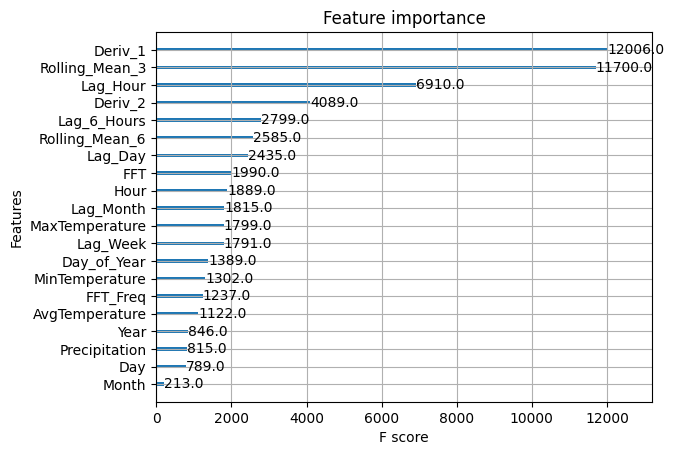

In [62]:
xgb.plot_importance(xgb_model)
plt.show()

<Axes: >

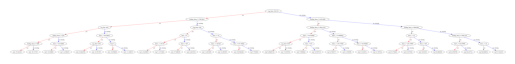

In [63]:
xgb.plot_tree(xgb_model, num_trees=12)

### 7.4. Neural Network / Deep Learning Models <a name="nndl"></a>

In [58]:
load_df = load_df[~load_df.isnull().any(axis = 1)]
load_df.reset_index(drop = True, inplace = True)
#load_df.drop('index', inplace = True, axis = 1)
load_df.reset_index(drop = False, inplace = True)
#load_df[['zone', 'Hour', 'Day', 'Month', 'Year', 'Day_of_Year']] = load_df[['zone', 'Hour', 'Day', 'Month', 'Year', 'Day_of_Year']].astype(str).astype('category')
load_df.rename(columns = {'index' : 'time_idx'}, inplace = True)

# train_pytorch = load_df.loc[load_df['Date'] < pd.to_datetime(train_cutoff)]
# val_pytorch = load_df.loc[(load_df['Date'] >= pd.to_datetime(train_cutoff)) & 
#                         (load_df['Date'] < pd.to_datetime(test_cutoff))]
# test_pytorch = load_df.loc[load_df['Date'] >= pd.to_datetime(test_cutoff)]

train_pytorch = load_df.loc[(load_df['Date'] >= pd.to_datetime(train_cutoff)) & 
                         (load_df['Date'] < pd.to_datetime(test_cutoff))]

In [59]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

# MacOS - Set cuda device to mps.
import torch
print(torch.backends.mps.is_available())
torch.device('mps')

True


device(type='mps')

In [60]:
train_pytorch.rename(columns = {'Date' : 'ds', 'mw' : 'y', 'zone' : 'unique_id'}, inplace = True)
train_pytorch_static = pd.DataFrame({'unique_id' : zones,
                                     'zones' : zones})
train_pytorch_static = train_pytorch_static.join(pd.get_dummies(train_pytorch_static['zones'], dtype = int))
train_pytorch_static.drop(['zones'], axis = 1, inplace = True)
train_pytorch_static

/var/folders/m8/939h_p3x6fq4_c0w_pfktz840000gn/T/ipykernel_42596/1748305076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_pytorch.rename(columns = {'Date' : 'ds', 'mw' : 'y', 'zone' : 'unique_id'}, inplace = True)


,unique_id,AE,CE,DOM,JC,PEP
0,AE,1,0,0,0,0
1,CE,0,1,0,0,0
2,DOM,0,0,1,0,0
3,JC,0,0,0,1,0
4,PEP,0,0,0,0,1


In [64]:
train_pytorch = train_pytorch[train_pytorch.ds.between(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-06-30 23:00:00'), inclusive='both')]
pytorch_cutoff = pd.to_datetime('2020-05-01')
train_pytorch_train = train_pytorch[train_pytorch.ds < pytorch_cutoff]
train_pytorch_val = train_pytorch[train_pytorch.ds >= pytorch_cutoff].reset_index(drop = True)

In [94]:
# Set environment variable since pytorch lacks some functionality on apple silicon still.
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

input_size_train = int(len(train_pytorch_train[train_pytorch_train.unique_id == 'AE']) / 2.75)
h_size_val = len(train_pytorch_val[train_pytorch_val.unique_id == 'AE'])
nf = NeuralForecast(
    models = [TFT(h = h_size_val,
                  input_size = input_size_train, # AR input size (t-input_size : t)
                  hidden_size = 20,
                  #loss = DistributionLoss(distribution = 'Poisson', level = [80, 90]),
                  #loss = DistributionLoss(distribution = 'Normal', level = [80, 90]),
                  loss = DistributionLoss(distribution = 'StudentT', level = [80, 90]),
                  learning_rate = 0.005,
                  stat_exog_list = ['AE', 'CE', 'DOM', 'JC', 'PEP'],
                #   futr_exog_list = ['MaxTemperature', 'MinTemperature', 'AvgTemperature',
                #                     'Precipitation', 'Hour', 'Day',
                #                     'Month', 'Year', 'Day_of_Year',
                #                     'Rolling_Mean_3','Rolling_Mean_6','Lag_Hour',
                #                     'Lag_6_Hours','Lag_Day','Lag_Week',
                #                     'Lag_Month','Deriv_1','Deriv_2',
                #                     'FFT', 'FFT_Freq'],
                  hist_exog_list = ['time_idx'],
                  max_steps = 500,
                  val_check_steps = 10,
                  early_stop_patience_steps = 10,
                  scaler_type = 'robust',
                  windows_batch_size = None,
                  enable_progress_bar = True,
                  accelerator = 'cpu', # set to cpu for now, mps not working..
                  start_padding_enabled = True), 
                  ],
            freq = 'H' # Hourly
            )
nf.fit(df = train_pytorch_train, static_df = train_pytorch_static, val_size = len(train_pytorch_val), verbose = True)
Y_hat_df = nf.predict(futr_df = train_pytorch_val)

# Plot quantile predictions
Y_hat_df = Y_hat_df.reset_index(drop = False).drop(columns = ['unique_id', 'ds'])
plot_df = pd.concat([train_pytorch_val, Y_hat_df], axis = 1)
plot_df = pd.concat([train_pytorch_train, plot_df])

plot_df = plot_df[plot_df.unique_id == 'AE'].drop('zone', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c = 'black', label = 'True')
plt.plot(plot_df['ds'], plot_df['TFT'], c = 'purple', label = 'mean')
plt.plot(plot_df['ds'], plot_df['TFT-median'], c = 'blue', label = 'median')
plt.fill_between(x = plot_df['Date'][-len(train_pytorch_val): ], 
                 y1 = plot_df['TFT-lo-90'][-len(train_pytorch_val): ].values, 
                 y2 = plot_df['TFT-hi-90'][-len(train_pytorch_val): ].values,
                 alpha = 0.4, label = 'level 90')
plt.legend()
plt.grid()
plt.plot()

/opt/homebrew/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
/opt/homebrew/lib/python3.11/site-packages/neuralforecast/core.py:441: UserWarning: Validation set size is larger than the shorter time-series.
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name                    | Type                     | Params
---------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5     
1 | padder_train            | ConstantPad1d    

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


: 

## 8. Results Evaluation <a name="eval"></a>

---



### 8.1. Evaluation Helper Functions <a name="evalhelper"></a>


In [ ]:
model_selector = {'Naive' : naive,
                  'Mean' : mean,
                  'XGBoost': xgb_model}

In [ ]:
def RMSE(model, forecast_horizon):
    model_selector = {'Naive' : naive,
                      'Mean' : mean,
                      'XGBoost': xgb_model}
    RMSE_result = {}
    for zone in zones:     
        RMSE_result[zone] = []
        y_pred = model_selector[model][zone][forecast_horizon]
        y_test_horizon = generate_y_test_horizon(zone, forecast_horizon)
        RMSE_result[zone] = np.sqrt(sum((y_test_horizon - y_pred)**2)/len(y_test_horizon))

    return RMSE_result

In [ ]:
pd.DataFrame(RMSE('Naive', '1H'), index = ['1H'])

In [ ]:
# results = pd.DataFrame()
# for horizon in horizon_selector:
#     print(horizon, RMSE('Naive', horizon))
#     df_index = pd.MultiIndex.from_product([['RMSE'],['Naive'],[horizon]], names = ['Metric', 'Model', 'Horizon'])
#     results = pd.concat([results, pd.DataFrame(RMSE('Naive', horizon), index = df_index)])

results = pd.DataFrame()
for model in model_selector:
    for horizon in horizon_selector:
        print(horizon, RMSE(model, horizon))
        df_index = pd.MultiIndex.from_product([['RMSE'],[model],[horizon]], names = ['Metric', 'Model', 'Horizon'])
        results = pd.concat([results, pd.DataFrame(RMSE(model, horizon), index = df_index)])
#results = pd.concat([results, pd.DataFrame(sigma, index = df_index)])

In [ ]:
results

In [ ]:
results.iloc[3:11:6]

In [ ]:
sigma

In [ ]:
# Use this for test forecast horizons.
for horizon in horizon_selector:
    print(horizon_selector[horizon])
    
# for horizon in horizon_selector:
#     print(horizon)
#     X_test_horizon = X_test.loc[X_test.index <= X_test.index.min() + horizon_selector[horizon]]
#     y_test_horizon = y_test.loc[y_test.index <= y_test.index.min() + horizon_selector[horizon]]

## Generation Situation

---

Keeping all the energy generation code here until I decide how it fits into this project. Might spin off into its own depending on timing.

In [ ]:
data_folder_gen = current_wdir + '/Data/Gen_by_Fuel'

In [ ]:
file_path_gen = [f'{data_folder_gen}/{file}' for file in os.listdir(data_folder_gen) if '.csv' in file]
file_path_gen = sorted(file_path_gen)

In [ ]:
gen_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_gen], join = 'outer', ignore_index = False, axis = 0)

In [ ]:
display(gen_df)
display(gen_df.dtypes)

In [ ]:
gen_df[date_cols] = gen_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)

In [ ]:
gen_fuel_df = gen_df[['datetime_beginning_ept', 'fuel_type', 'mw']].groupby(['datetime_beginning_ept', 'fuel_type'], as_index = False).sum()

In [ ]:
palette = ['#570408', '#005d5d', '#1192e8', '#9f1853', '#ee538b', '#012749', '#009d9a', '#002d9c', '#fa4d56', '#198038', '#b28600', '#6929c4']

ax, fig = plt.subplots(figsize = (14, 4))
ax = sns.lineplot(gen_fuel_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'fuel_type', alpha = 0.7, lw = 1, palette = sns.color_palette(palette, 12))
ax.margins(x = 0)
ax.set_xlabel('Time')
ax.set_ylabel('Megawatts (MW)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Coal'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

In [ ]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

In [ ]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Solar'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

## Seeking the Prophet

---

Just temporarily building a model from Meta's Prophet to use in a few visualizations.

Feelin' cute, might delete later.

In [ ]:
df = pd.DataFrame({'ds' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['datetime_beginning_ept'],
                   'y' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['mw']})
m = Prophet()
m.fit(df)

In [ ]:
future = m.make_future_dataframe(periods=365*2)
display(future.tail())
forecast = m.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
fig1 = m.plot(forecast)
ax = fig1.gca()
plt.axvline(max(df['ds']), color = 'purple', ls = '--')

In [ ]:
# Sourced from the prophet repository and repurposed to include:
# - Delineate observed data and forecasted data (dashed line)
# - Separate observed data and forecasted data for different visuals
# - Color changes
# - Zoom into the last few years to better visualize forecast (currently hardcoded)

def prophetplot(m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='Time', ylabel='Megawatts (MW)',
    figsize=(10, 6), include_legend=False):
    """Plot the Prophet forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.
    Returns
    -------
    A matplotlib figure.
    """
    user_provided_ax = False if ax is None else True
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds']#.dt.to_pydatetime()

    # Initialize the observation and forecast data variables
    # Finds and separates the two sets by using the max date in (observed) input data.
    obs_t = fcst_t.loc[fcst_t < max(df['ds'])]
    obs_yhat = fcst['yhat'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_lower = fcst['yhat_lower'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_upper = fcst['yhat_upper'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    fc_t = fcst_t.loc[fcst_t >= max(df['ds'])]
    fc_yhat = fcst['yhat'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_lower = fcst['yhat_lower'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_upper = fcst['yhat_upper'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]

    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], '.', c = '#012749', markersize = 1, alpha = 0.9,
            label='Observed data points')
    ax.plot(obs_t, obs_yhat, ls='-', c='#005d5d', label='Forecast', lw = 0.75, alpha = 0.9)
    ax.plot(fc_t, fc_yhat, ls='-', c='#382238', label='Predict', lw = 0.75, alpha = 1)
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k', label='Maximum capacity')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k', label='Minimum capacity')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(obs_t, obs_lower, obs_upper,
                        color='#009d9a', alpha=0.4, label='Uncertainty interval')
        ax.fill_between(fc_t, fc_lower, fc_upper,
                        color='#753f75', alpha=0.4, label='Uncertainty interval')
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=0.75, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Zoom in x-axis closer to prediction.
    ax.set_xlim(pd.to_datetime(['2020-01-01 00:00:00', '2026-01-01 00:00:00']))
    ax.set_ylim(0, 90000)

    # Prediction divider line.
    plt.axvline(max(df['ds']), color = 'black', ls = '--', lw = 1.2)

    # Linear trend line to calculate yearly increase.
    obs_poly_fn = np.poly1d(np.polyfit(range(len(obs_t)), obs_yhat, 1))
    plt.plot(obs_t, obs_poly_fn(range(len(obs_t))), c = '#913529')

    fc_poly_fn = np.poly1d(np.polyfit(range(len(fc_t)), fc_yhat, 1))
    plt.plot(fc_t, fc_poly_fn(range(len(fc_t))), c = '#252f9c')

    if include_legend:
        ax.legend()
        plt.legend(loc = 'upper left')
    if not user_provided_ax:
        fig.tight_layout()
    return fig

In [ ]:
prophetplot(m, forecast)
plt.show()

## Appendix A - Online References: <a name="appendixa"></a>

Here I will list a few resources that helped me along the way in no particular order.

1. Great bookdown text about forecasting basics - https://otexts.com/fpp2/stationarity.html#stationarity
2. Nice feature engineering list to help get started - https://hackernoon.com/advanced-techniques-for-time-series-data-feature-engineering
3. Open-source library/framework for good time series forecasting practices - https://nixtlaverse.nixtla.io/